In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import resample
import seaborn as sns
from sklearn.compose import ColumnTransformer
from collections import Counter
from sklearn.preprocessing import FunctionTransformer

missingno implementation

In [2]:
def create_submission_csv(predictions, filename):
    column_mapping = {
        0: '0',
    }
    
    predictions_df = pd.DataFrame(predictions)
    
    predictions_df.rename(columns=column_mapping, inplace=True)
    
    predictions_df.insert(0, 'id', range(len(predictions_df)))
    
    predictions_df.to_csv(filename+'.csv', index=False)
    
    print(f"CSV file '{filename}' has been created.")    

<Axes: >

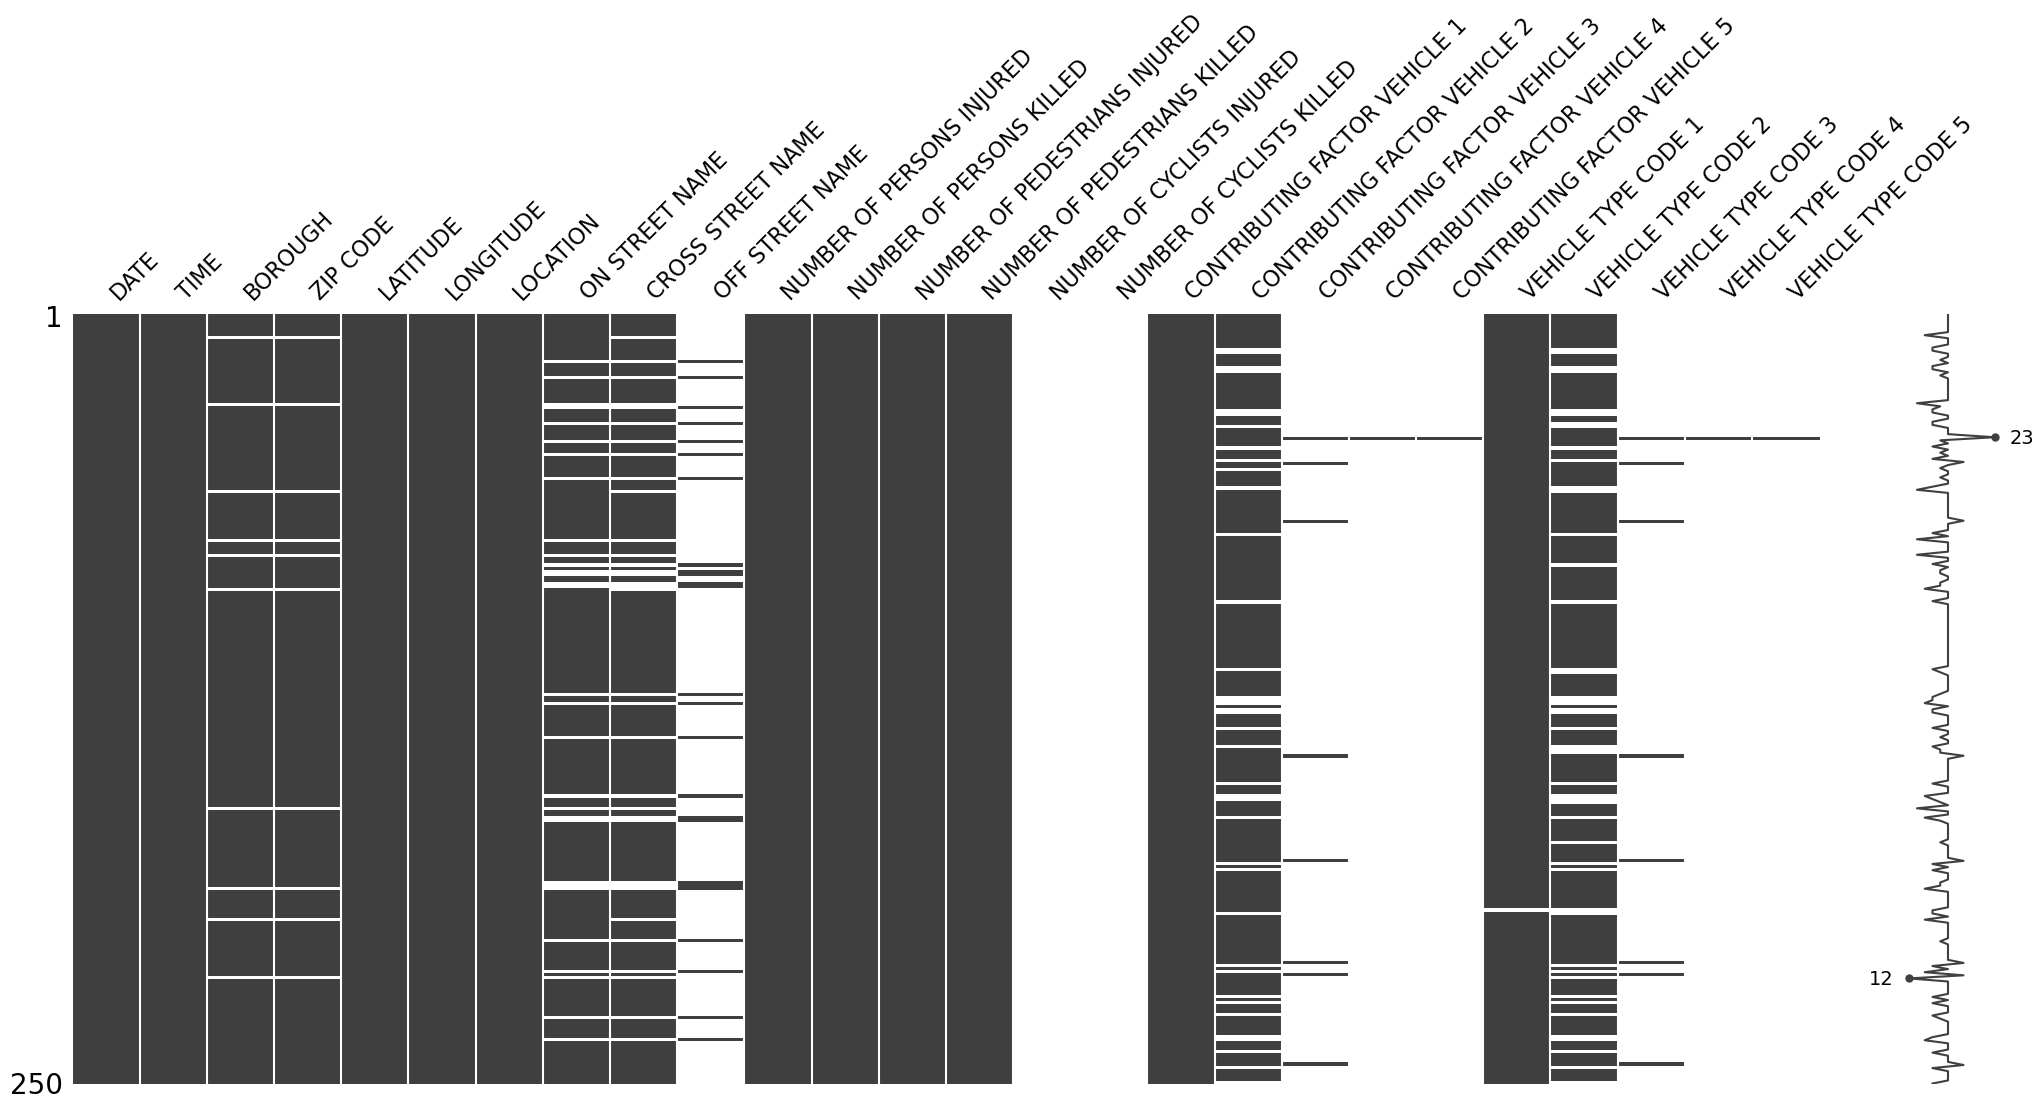

In [3]:
collisions = pd.read_csv("https://raw.githubusercontent.com/ResidentMario/missingno-data/master/nyc_collision_factors.csv")
import missingno as msno
%matplotlib inline
msno.matrix(collisions.sample(250))

In [4]:
trainDF = pd.read_csv("data/train_data.csv", sep=",")
testDF = pd.read_csv("data/test_data.csv", sep=",")
trainDF = trainDF.drop(['id'], axis=1)
testDF = testDF.drop(['id'], axis=1)
trainDF.info()
trainDF

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                400 non-null    float64
 1   Gender             400 non-null    int64  
 2   Stage              400 non-null    int64  
 3   GeneticRisk        315 non-null    float64
 4   TreatmentType      400 non-null    int64  
 5   ComorbidityIndex   355 non-null    float64
 6   TreatmentResponse  371 non-null    float64
 7   SurvivalTime       240 non-null    float64
 8   Censored           400 non-null    int64  
dtypes: float64(5), int64(4)
memory usage: 28.2 KB


,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime,Censored
0,65.0,0,2,1.0,0,0.0,0.0,4.2,0
1,68.0,1,2,0.0,1,1.0,1.0,4.7,1
2,68.0,1,3,1.0,1,0.0,1.0,3.5,1
3,81.0,1,4,1.0,1,3.0,0.0,2.3,0
4,59.0,1,2,1.0,0,NaN,0.0,NaN,0
...,...,...,...,...,...,...,...,...,...
395,66.0,0,3,0.0,1,0.0,1.0,NaN,0
396,72.0,1,2,NaN,0,2.0,1.0,7.2,0
397,69.0,0,2,0.0,0,1.0,1.0,NaN,0
398,63.0,0,4,0.0,1,2.0,1.0,8.1,0


In [5]:
testDF

,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse
0,71.0,1,4,NaN,1,1.0,1.0
1,57.0,1,4,0.0,0,NaN,0.0
2,66.0,0,2,0.0,0,0.0,1.0
3,73.0,0,3,NaN,1,1.0,1.0
4,53.0,1,4,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...
95,59.0,0,1,0.0,1,NaN,NaN
96,70.0,1,3,NaN,1,2.0,0.0
97,67.0,1,1,1.0,0,0.0,NaN
98,61.0,1,2,0.0,0,2.0,1.0


In [6]:
startDF = trainDF
startDF

,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime,Censored
0,65.0,0,2,1.0,0,0.0,0.0,4.2,0
1,68.0,1,2,0.0,1,1.0,1.0,4.7,1
2,68.0,1,3,1.0,1,0.0,1.0,3.5,1
3,81.0,1,4,1.0,1,3.0,0.0,2.3,0
4,59.0,1,2,1.0,0,NaN,0.0,NaN,0
...,...,...,...,...,...,...,...,...,...
395,66.0,0,3,0.0,1,0.0,1.0,NaN,0
396,72.0,1,2,NaN,0,2.0,1.0,7.2,0
397,69.0,0,2,0.0,0,1.0,1.0,NaN,0
398,63.0,0,4,0.0,1,2.0,1.0,8.1,0


Testing for dropping all values at NaN and censored values:

In [7]:
df = trainDF.dropna()
df = df[df['Censored'] != 1]
df

,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime,Censored
0,65.0,0,2,1.0,0,0.0,0.0,4.2,0
3,81.0,1,4,1.0,1,3.0,0.0,2.3,0
9,68.0,1,1,0.0,0,1.0,1.0,6.4,0
12,66.0,1,2,0.0,0,1.0,1.0,9.1,0
16,63.0,1,1,1.0,1,1.0,1.0,3.0,0
...,...,...,...,...,...,...,...,...,...
384,90.0,1,2,1.0,0,1.0,0.0,4.1,0
389,53.0,1,2,0.0,0,0.0,1.0,5.3,0
392,52.0,1,4,1.0,0,0.0,0.0,3.6,0
398,63.0,0,4,0.0,1,2.0,1.0,8.1,0


In [8]:
#c = startDF['Censored']
#startDF = startDF.dropna()
#startDF
simpleDF = startDF.drop(columns=['GeneticRisk', 'ComorbidityIndex', 'TreatmentResponse'])
simpleDF = simpleDF.dropna()
simpleDF

,Age,Gender,Stage,TreatmentType,SurvivalTime,Censored
0,65.0,0,2,0,4.2,0
1,68.0,1,2,1,4.7,1
2,68.0,1,3,1,3.5,1
3,81.0,1,4,1,2.3,0
5,47.0,1,4,1,2.6,0
...,...,...,...,...,...,...
391,80.0,0,2,0,2.3,0
392,52.0,1,4,0,3.6,0
396,72.0,1,2,0,7.2,0
398,63.0,0,4,1,8.1,0


In [9]:
simpleTestDF = testDF.drop(columns=['GeneticRisk', 'ComorbidityIndex', 'TreatmentResponse'])

<Axes: >

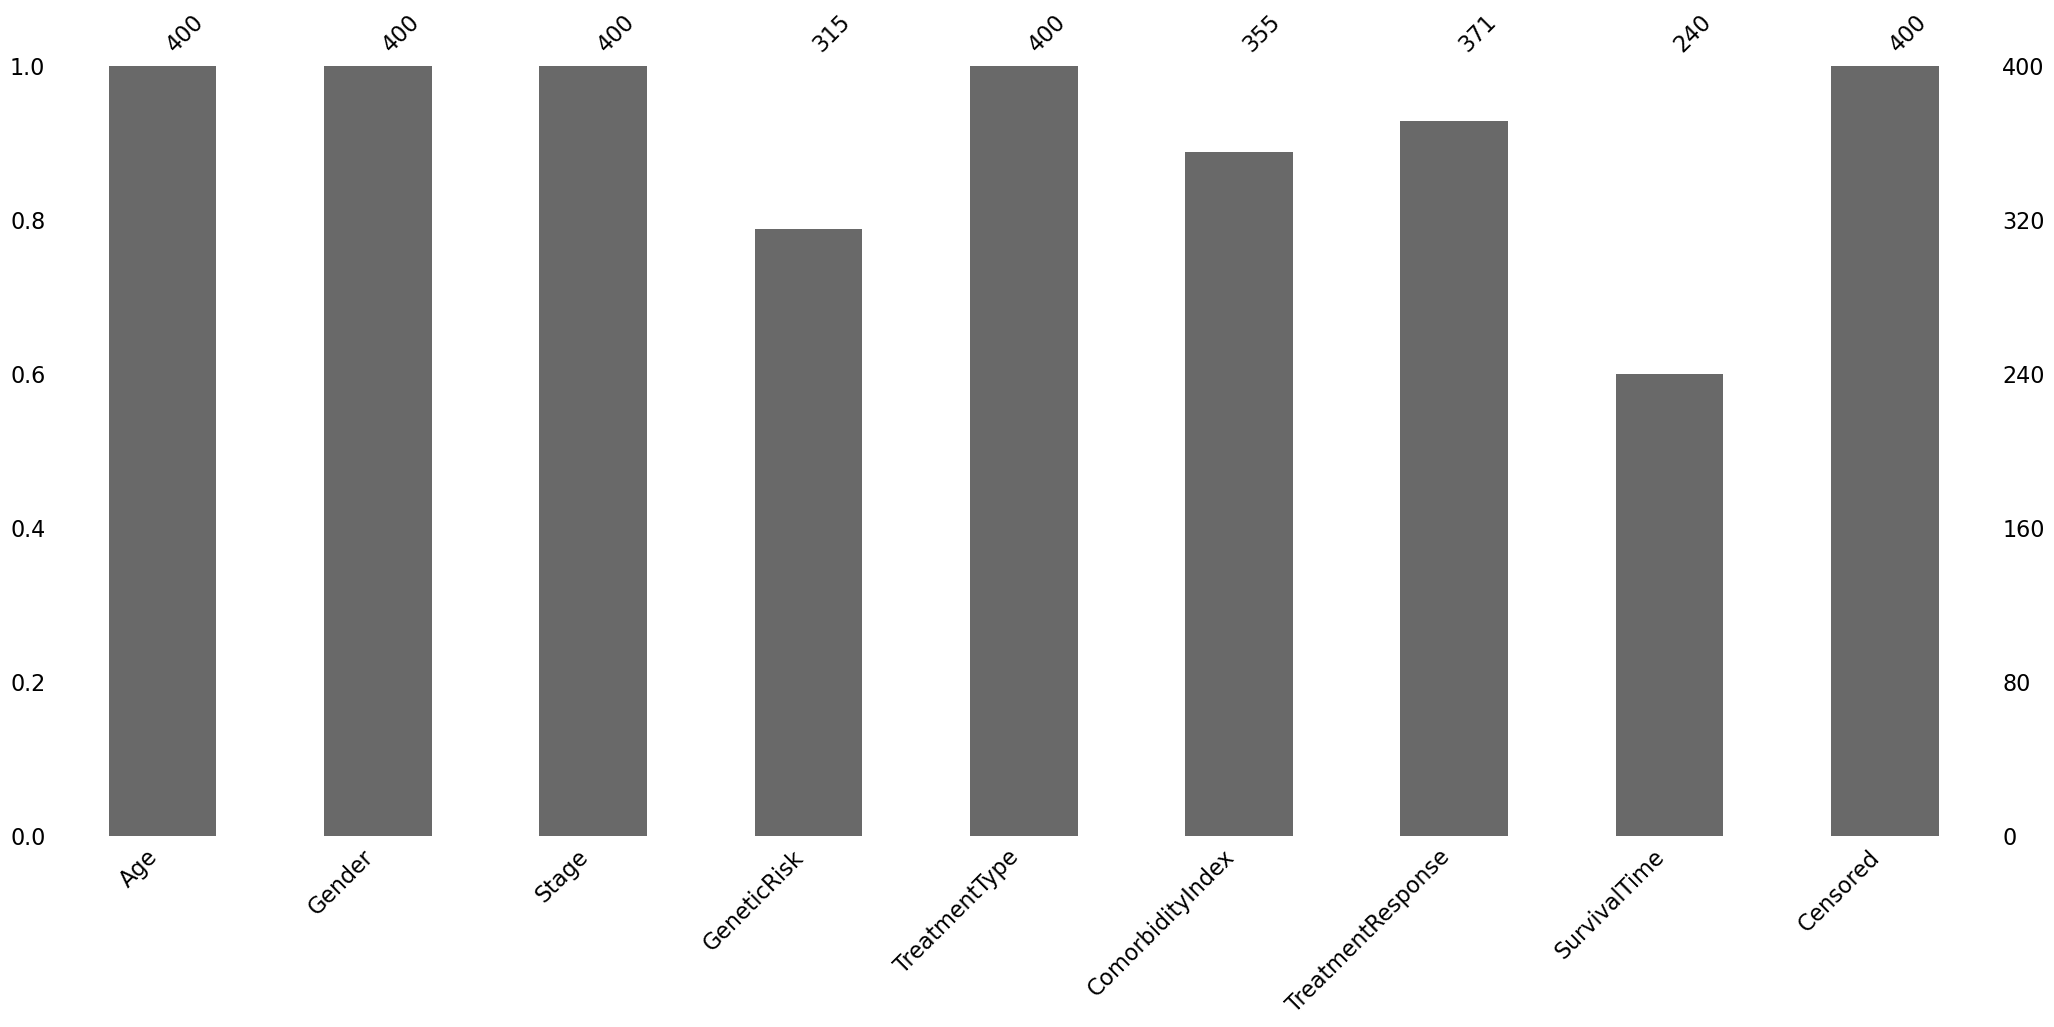

In [10]:
msno.bar(trainDF)

<Axes: >

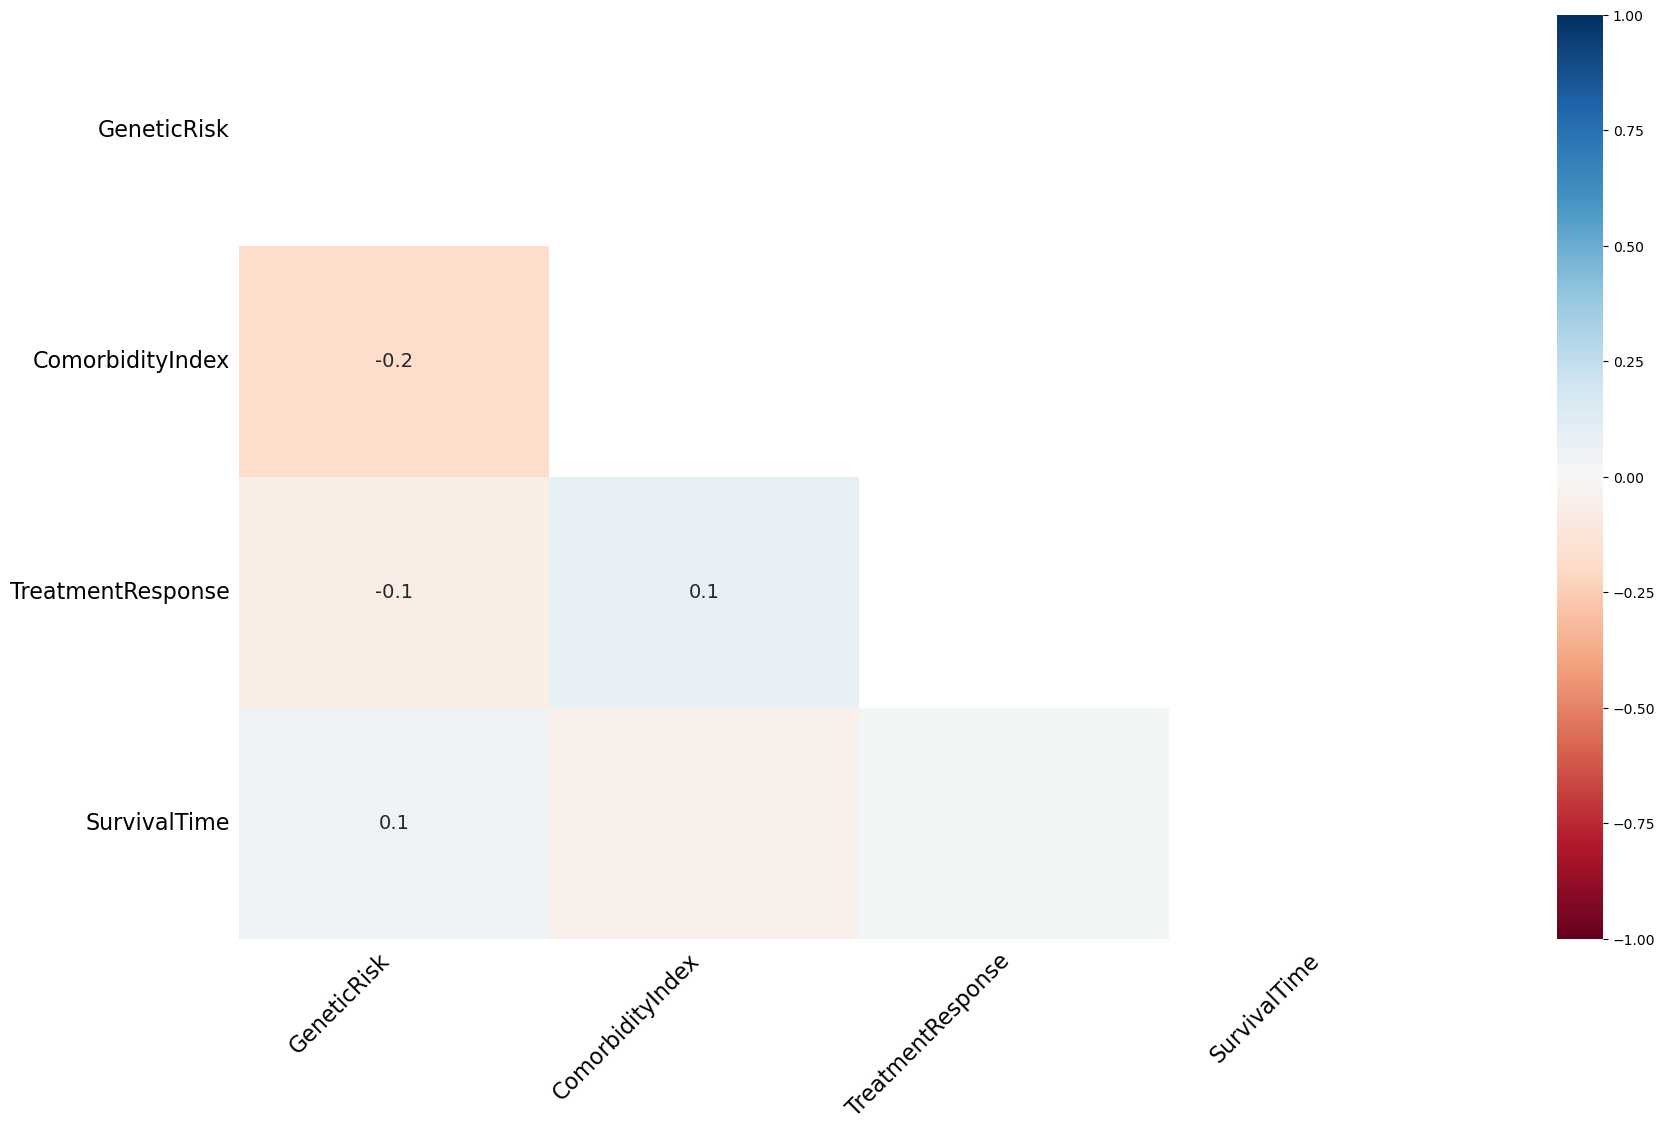

In [11]:
msno.heatmap(trainDF)

<Axes: >

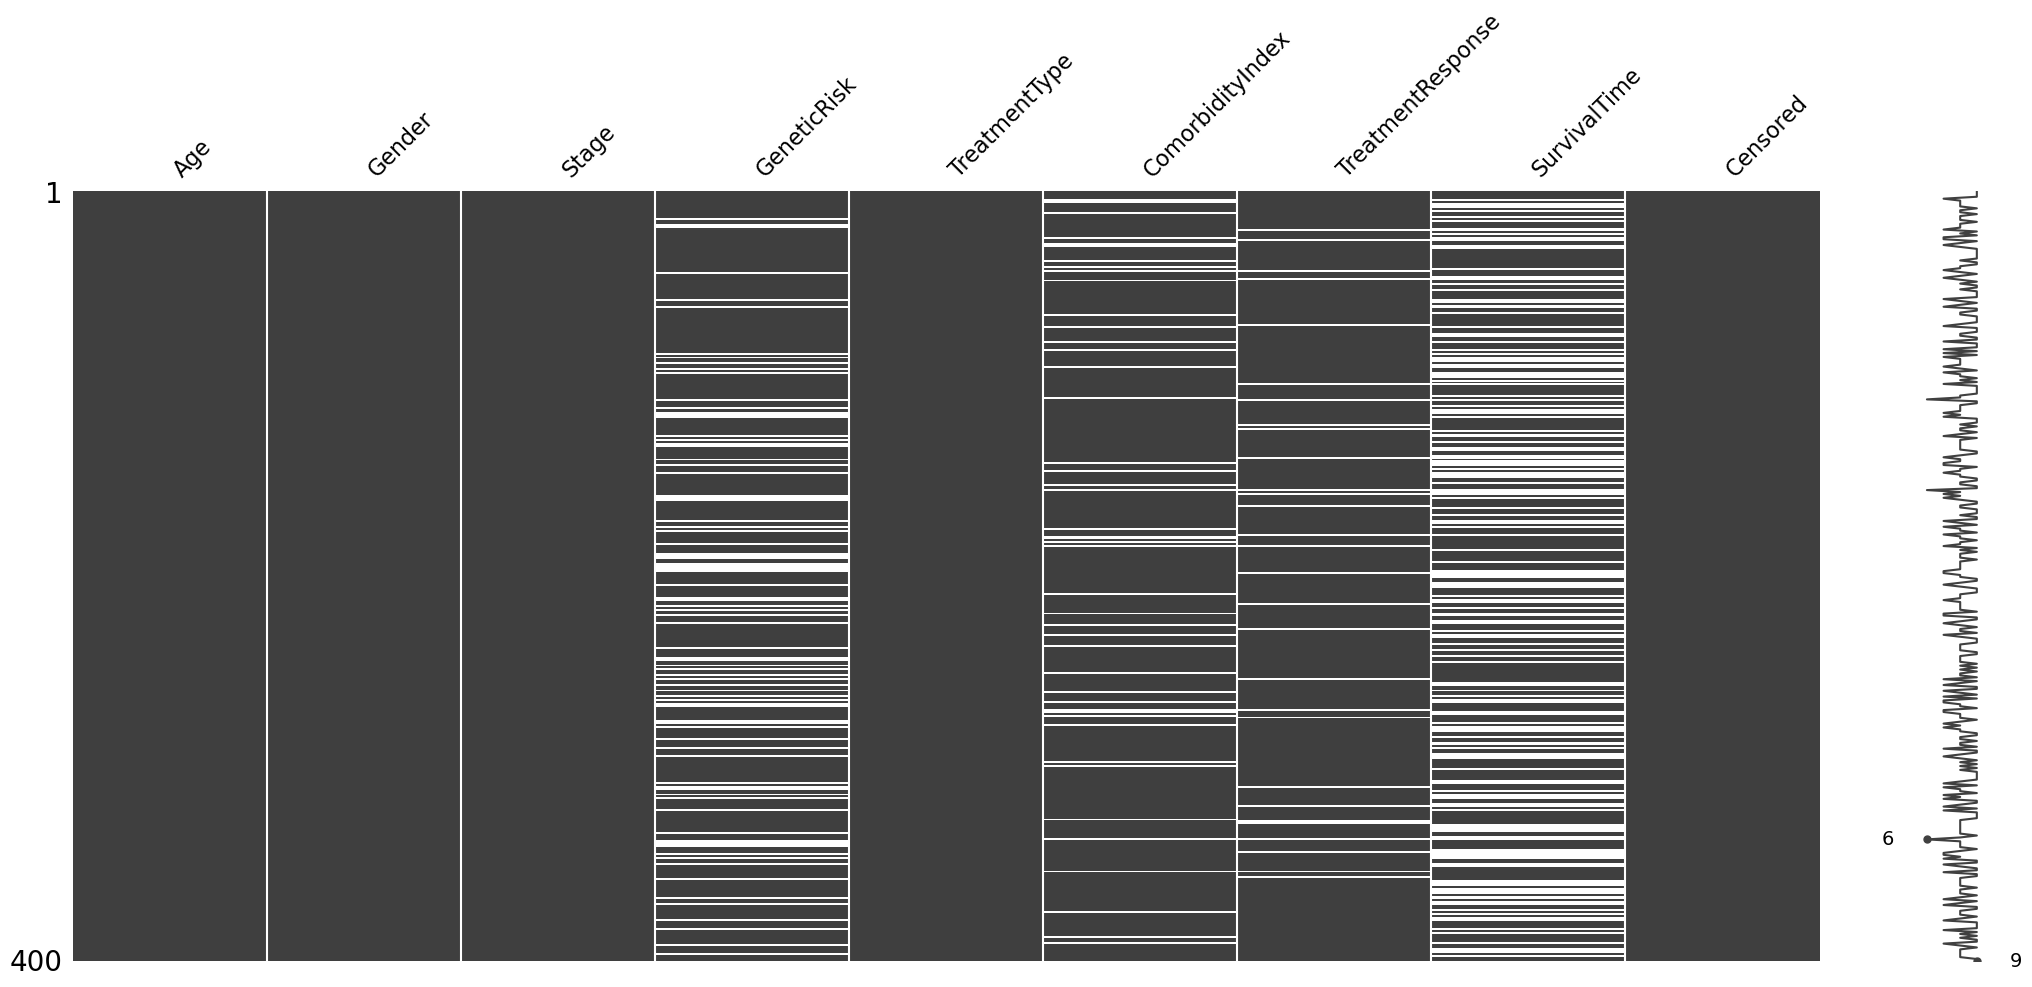

In [12]:
msno.matrix(trainDF)

<Axes: >

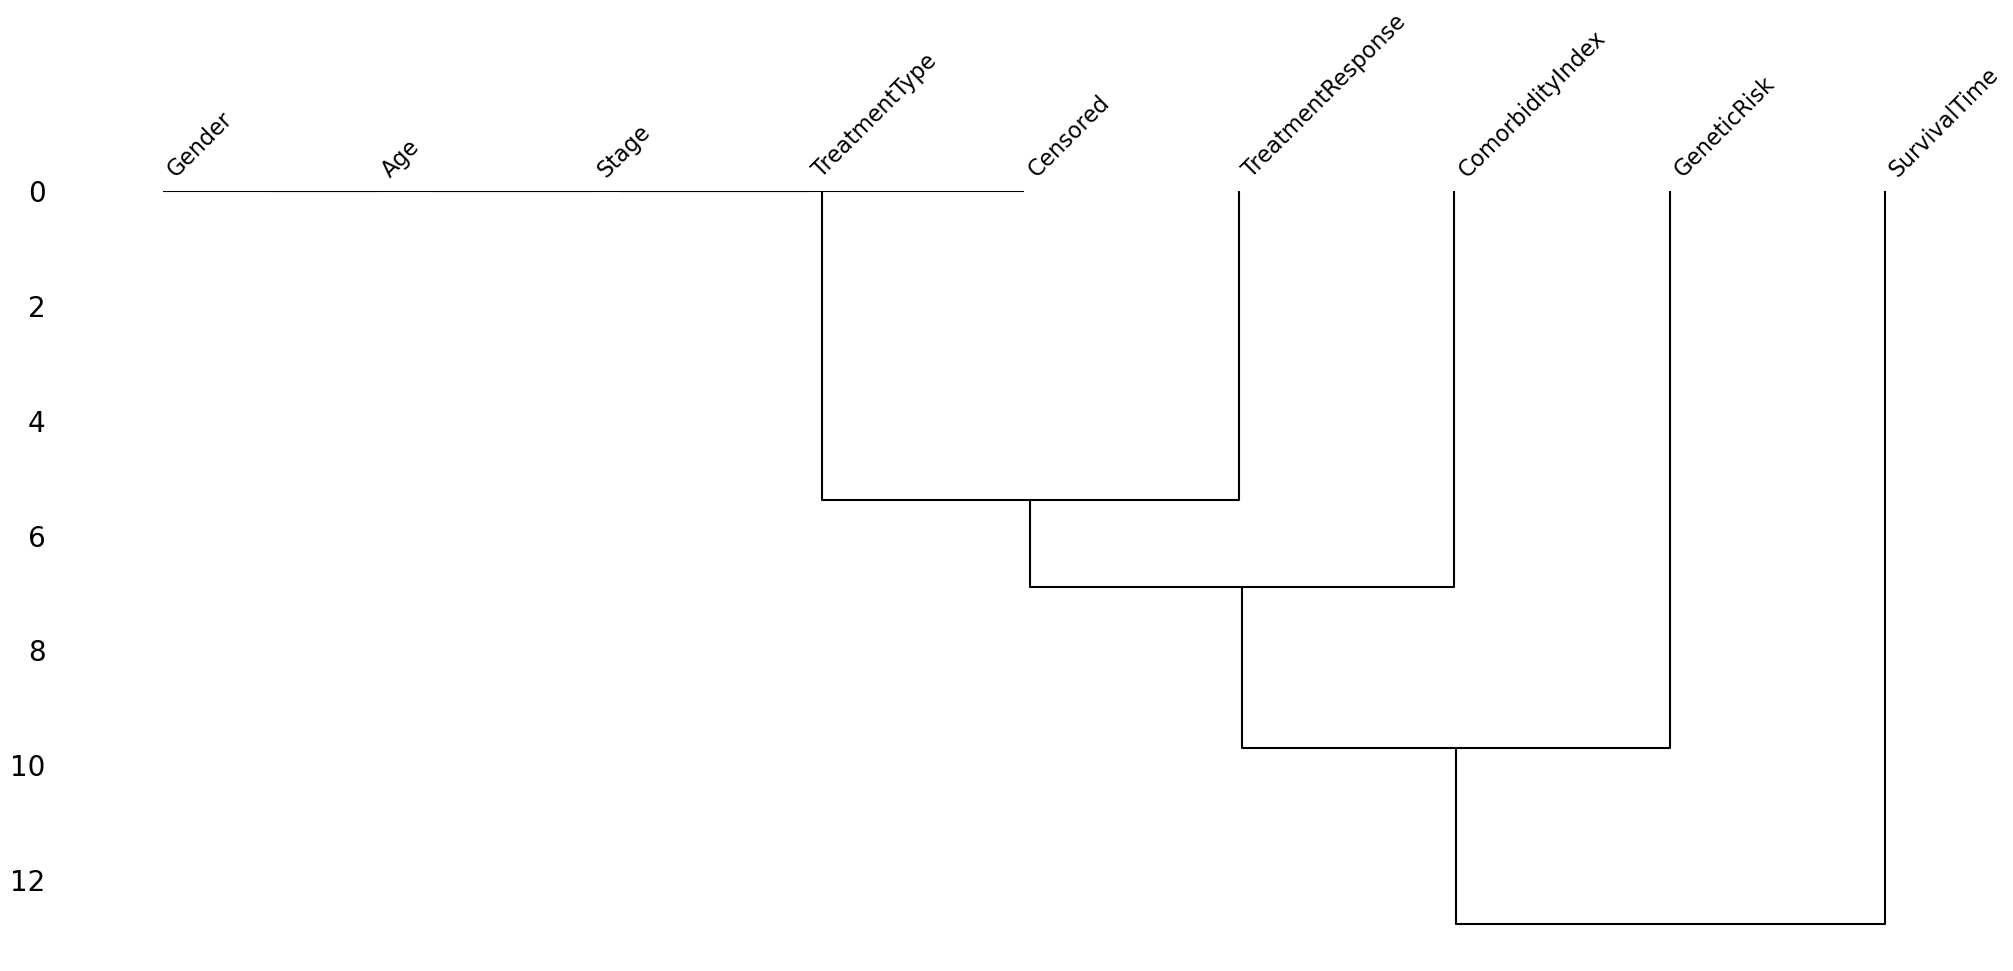

In [13]:
msno.dendrogram(trainDF)

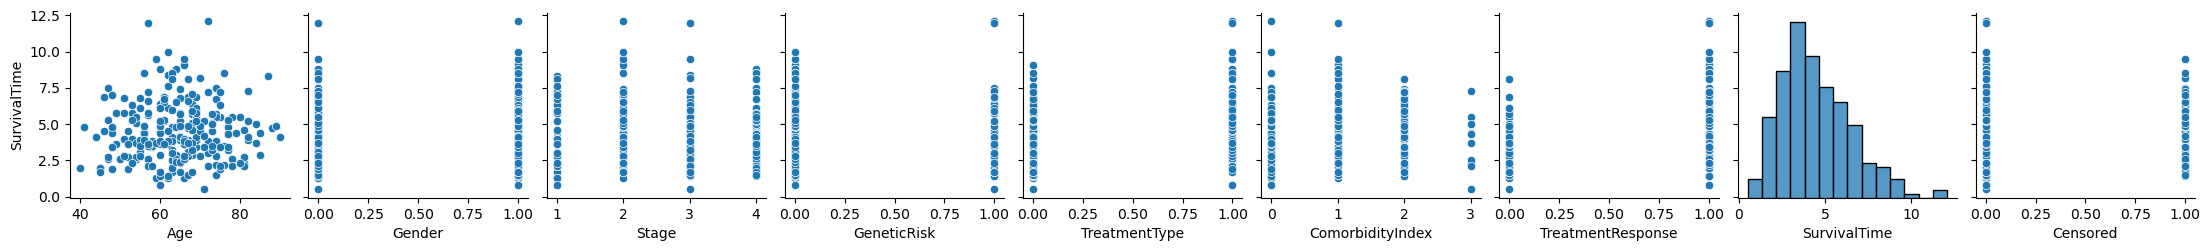

In [14]:
sns.pairplot(trainDF, y_vars='SurvivalTime', x_vars=trainDF, kind='scatter')

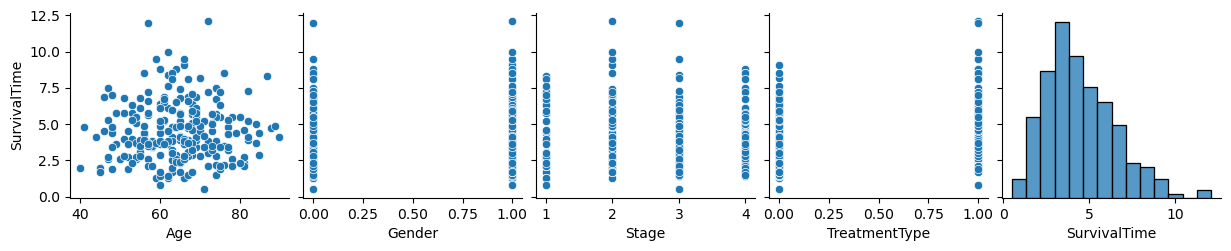

In [15]:
sns.pairplot(simpleDF, y_vars='SurvivalTime', x_vars=simpleDF.columns.drop('Censored'), kind='scatter')

In [16]:
def baselineData(dataframe):
    X = dataframe.drop(columns=['SurvivalTime', 'Censored'])
    y = dataframe['SurvivalTime']
    c = dataframe['Censored']
    return (X,y, c)
X, y, c = baselineData(simpleDF)

X

,Age,Gender,Stage,TreatmentType
0,65.0,0,2,0
1,68.0,1,2,1
2,68.0,1,3,1
3,81.0,1,4,1
5,47.0,1,4,1
...,...,...,...,...
391,80.0,0,2,0
392,52.0,1,4,0
396,72.0,1,2,0
398,63.0,0,4,1


In [17]:
y

0      4.2
1      4.7
2      3.5
3      2.3
5      2.6
      ... 
391    2.3
392    3.6
396    7.2
398    8.1
399    3.7
Name: SurvivalTime, Length: 240, dtype: float64

In [18]:
def error_metric(y, y_hat, c):
    err = y-y_hat
    err = (1-c)*err**2 + c*np.maximum(0,err)**2
    return np.sum(err)/err.shape[0]

Simple cross validation doesn't seem viable, but let's try it out

In [19]:
X_train, X_temp, y_train, y_temp, c_train, c_temp = train_test_split(X, y, c, test_size=0.3)    # Train/temp split ratio

X_val, X_test, y_val, y_test, c_val, c_test = train_test_split(X_temp, y_temp, c_temp, test_size=0.33)  # Val/test split ratio
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())]
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

cmse = error_metric(y_test, y_pred, c_test)
mse = root_mean_squared_error(y_true=y_test, y_pred=y_pred)

print("Train-Test-Validation split")
print('-----')
print("MSE:", mse)
print("CMSE:", cmse)

Train-Test-Validation split
-----
MSE: 1.606160867019138
CMSE: 2.0133318584307176


In [20]:
from sklearn.model_selection import KFold

bestAverageMSE = 300     # arbitrary large error (if it defaults to this, something is wrong already)
bestAverageCMSE = 300
worstAverageMSE = 0
worstAverageCMSE = 0
bestCMSEi = 0
bestMSEi = 0
worstCMSEi = 0
worstMSEi = 0

for folds in range(3, 16):  # K-fold validation range
    nfolds = folds
    print(f"----------- {folds} folds -----------")
    kf = KFold(n_splits=nfolds)
    model = LinearRegression()
    numpyX = X.to_numpy()
    numpyY = y.to_numpy()
    metrics = {'mse':[], 'cmse':[]}

    for i, (train_index, test_index) in enumerate(kf.split(numpyX)):

        X_train, X_test = numpyX[train_index], numpyX[test_index]
        y_train, y_test = numpyY[train_index], numpyY[test_index]

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)]
        )

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        c = simpleDF['Censored'].to_numpy()[test_index]

        cmse = error_metric(y_test, y_pred, c)
        mse = root_mean_squared_error(y_true=y_test, y_pred=y_pred)
        metrics['mse'].append(mse)
        metrics['cmse'].append(cmse)

    averageMSE = np.mean(metrics['mse'])
    averageCMSE = np.mean(metrics['cmse'])
    if bestAverageMSE > averageMSE:
        bestAverageMSE = averageMSE
        bestMSEi = folds
    if bestAverageCMSE > averageCMSE:
        bestAverageCMSE = averageCMSE
        bestCMSEi = folds
    if worstAverageMSE < averageMSE:
        worstAverageMSE = averageMSE
        worstMSEi = folds
    if worstAverageCMSE < averageCMSE:
        worstAverageCMSE = averageCMSE
        worstCMSEi = folds

    print("Average mse", averageMSE)
    print("Average cmse", averageCMSE)

----------- 3 folds -----------
Average mse 1.9685192405339862
Average cmse 3.4010723664188305
----------- 4 folds -----------
Average mse 1.9609119366299215
Average cmse 3.4218874126396743
----------- 5 folds -----------
Average mse 1.9674029241292856
Average cmse 3.4307478043130812
----------- 6 folds -----------
Average mse 1.9578409587155219
Average cmse 3.402027608565358
----------- 7 folds -----------
Average mse 1.949976249783519
Average cmse 3.435893794844857
----------- 8 folds -----------
Average mse 1.9348621789635152
Average cmse 3.4210179698036383
----------- 9 folds -----------
Average mse 1.9436591871276265
Average cmse 3.4126113152900457
----------- 10 folds -----------
Average mse 1.9506009517820715
Average cmse 3.440025398524759
----------- 11 folds -----------
Average mse 1.948480137916293
Average cmse 3.456891470097083
----------- 12 folds -----------
Average mse 1.9207557626609617
Average cmse 3.4213331945163383
----------- 13 folds -----------
Average mse 1.931310

In [21]:
print('K-Fold validation')
print('-----')
print("Best average mse:", bestAverageMSE, "with",bestMSEi,"folds")
print("Worst average mse:", worstAverageMSE, "with",worstMSEi,"folds")

print("Best average cmse:", bestAverageCMSE, "with",bestCMSEi,"folds")
print("Worst average cmse:", worstAverageCMSE, "with",worstCMSEi,"folds")

K-Fold validation
-----
Best average mse: 1.9207557626609617 with 12 folds
Worst average mse: 1.9685192405339862 with 3 folds
Best average cmse: 3.4010723664188305 with 3 folds
Worst average cmse: 3.456891470097083 with 11 folds


With these values, it should mean our predictions should be somewhere between in this cmse range, hopefully   

## Task 1.2 Learn the baseline model

In [22]:
X, y, c = baselineData(simpleDF)

pipeline = pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)]
        )
pipeline.fit(X, y)    # train the final pipeline in the full dataset

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

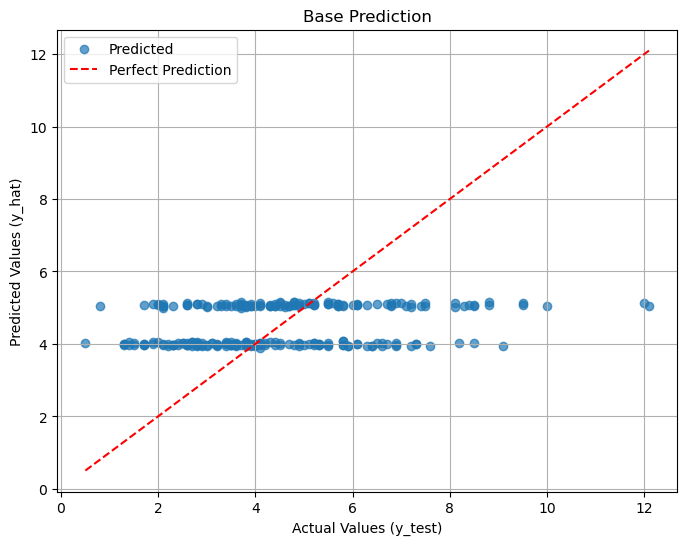

baseline model censored Mean Squared Error: 3.295382583041433
baseline model Mean Squared Error: 1.9361898235768644


In [23]:
def plot_y_yhat(y_test, y_hat, plot_title='Graph'):
    plt.figure(figsize=(8, 6))  # Plot dimensions
    
    # Scatter plot
    plt.scatter(y_test, y_hat, alpha=0.7, label='Predicted')    # alpha -> scatter plot transparency
    
    # Perfect prediction line
    y_sorted = np.sort(y_test)  # Ensure sorting for the line
    plt.plot(y_sorted, y_sorted, color='red', linestyle='--', label='Perfect Prediction')
    
    # Labels and title
    plt.xlabel('Actual Values (y_test)')
    plt.ylabel('Predicted Values (y_hat)')
    plt.title(plot_title)
    plt.legend()
    plt.grid(True)
    plt.show()

y_pred = pipeline.predict(X)
plot_y_yhat(y, y_pred, plot_title='Base Prediction')
cmse = error_metric(y, y_pred, c)
print(f"baseline model censored Mean Squared Error: {cmse}")
mse = root_mean_squared_error(y, y_pred)
print(f"baseline model Mean Squared Error: {mse}")

In [24]:
simpleTestDF

,Age,Gender,Stage,TreatmentType
0,71.0,1,4,1
1,57.0,1,4,0
2,66.0,0,2,0
3,73.0,0,3,1
4,53.0,1,4,0
...,...,...,...,...
95,59.0,0,1,1
96,70.0,1,3,1
97,67.0,1,1,0
98,61.0,1,2,0


In [25]:
#testing = testDF.dropna()
valid_rows = simpleTestDF.notna().all(axis=1)
predictions = np.full(simpleTestDF.shape[0], np.nan) #start all at NaN
predictions[valid_rows] = pipeline.predict(simpleTestDF[valid_rows])
mean_prediction = np.nanmean(predictions) #calculate the mean of the predictions
predictions[np.isnan(predictions)] = mean_prediction #pass NaN values to mean

In [26]:
create_submission_csv(predictions, "baseline-submission-7")

CSV file 'baseline-submission-7' has been created.


## Task 1.3 Learn with the cMSE

In [27]:
dfWithoutCensored = simpleDF.drop(columns=['Censored'])

means = dfWithoutCensored.mean()
stds = dfWithoutCensored.std()

normalized_data = (dfWithoutCensored - means) / stds

normalized_data

,Age,Gender,Stage,TreatmentType,SurvivalTime
0,0.028196,-1.232865,-0.575508,-0.902648,-0.138726
1,0.331201,0.807739,-0.575508,1.103236,0.109368
2,0.331201,0.807739,0.377057,1.103236,-0.486056
3,1.644223,0.807739,1.329622,1.103236,-1.081481
5,-1.789834,0.807739,1.329622,1.103236,-0.932625
...,...,...,...,...,...
391,1.543222,-1.232865,-0.575508,-0.902648,-1.081481
392,-1.284826,0.807739,1.329622,-0.902648,-0.436438
396,0.735208,0.807739,-0.575508,-0.902648,1.349835
398,-0.173807,-1.232865,1.329622,1.103236,1.796403


In [28]:
#the custom Mean Squared Error (cMSE) cost function
def cmse_cost_function(X, y, alpha, c):    

  y_pred = X.dot(alpha)
  err = y_pred - y
    
  # Different cost for uncensored and censored data
  cost = np.sum((1-c) * err**2 + c * np.maximum(0, err)**2) / (2 * len(y))
    
  return cost

# the gradient for the custom Mean Squared Error
def cmse_gradient(X, y, alpha, c):

  y_pred = X.dot(alpha)

  # Compute gradient for each data point
  grad = np.zeros_like(alpha)
  for i in range(len(y)):
    if c[i] == 0:  # Uncensored data
      grad += (y_pred[i] - y[i]) * X[i]
    else:  # Censored data
      if y_pred[i] > y[i]:
        grad += (y_pred[i] - y[i]) * X[i]

  return grad / len(y)


In [29]:
def cmse_gradient_descent(X, y, c, alpha, learning_rate, n_iters):
    cost_history = []
    for i in range(n_iters):
        grad = cmse_gradient(X, y, alpha, c)
        
        # Update weights
        alpha = alpha - learning_rate * grad
        
        # Compute and store cost
        cost = cmse_cost_function(X, y, alpha, c)
        cost_history.append(cost)
            
    return np.array(cost_history), alpha


In [30]:
cost_histories = []
closed_costs = []

def doGradient(dataframe):

    X = dataframe.drop(columns=['SurvivalTime', 'Censored'])
    y = dataframe['SurvivalTime']
    c = dataframe['Censored']

    X_normalized = (X - X.mean()) / X.std()

    X_with_bias = np.hstack([np.ones((X_normalized.shape[0], 1)), X_normalized])

    alpha = np.zeros(X_with_bias.shape[1])

    cost_history, optimal_alpha = cmse_gradient_descent(X_with_bias, y.values, c.values, alpha, 
                                                        learning_rate=0.01, n_iters=1000)

    plt.figure(figsize=(10, 6))
    plt.plot(cost_history)
    plt.title('Cost History')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.show()

    return optimal_alpha, cost_history

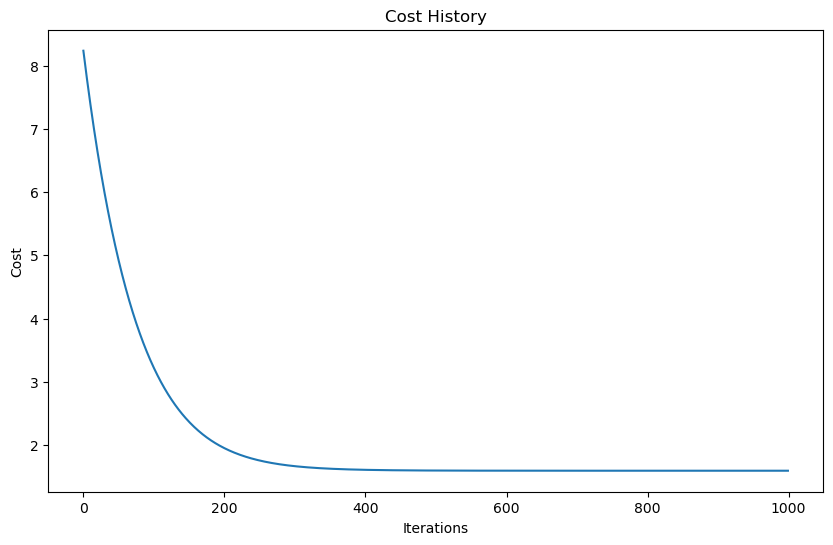

In [31]:
optimal_alpha, cost_history = doGradient(simpleDF)

In [32]:
print(optimal_alpha)

[ 4.24158695 -0.05162589  0.05441984  0.10092483  0.49621482]


These are the alphas (weights) for each of our features   
First value is the bias

In [33]:
def predict_with_weight(features, optimal_alpha):
    X_normalized = (features - features.mean()) / features.std()
    
    # Add bias term
    X_with_bias = np.hstack([np.ones((X_normalized.shape[0], 1)), X_normalized])
    
    # Predict
    return X_with_bias.dot(optimal_alpha)

In [34]:
X, y, c = baselineData(simpleDF)

X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(X, y, c, test_size=0.2)


y_pred = predict_with_weight(X_test, optimal_alpha=optimal_alpha)

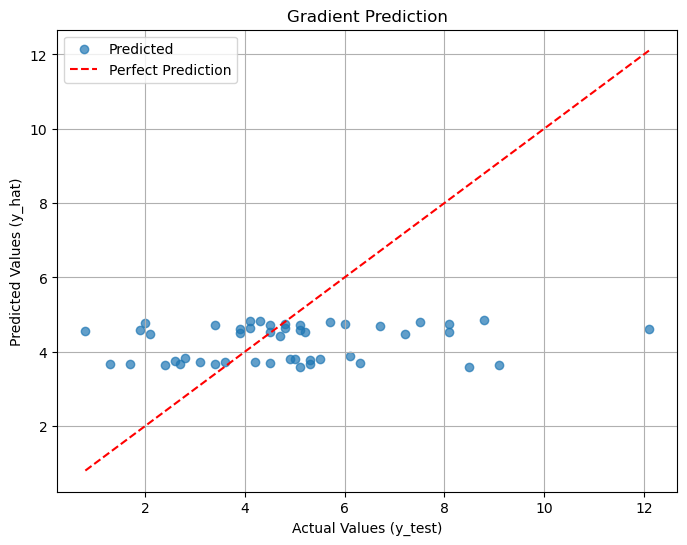

Prediction with weight CMSE: 5.13525345907905


In [35]:
plot_y_yhat(y_test, y_pred, plot_title='Gradient Prediction')
cmse = error_metric(y_test, y_pred, c_test)
print('Prediction with weight CMSE:', cmse)

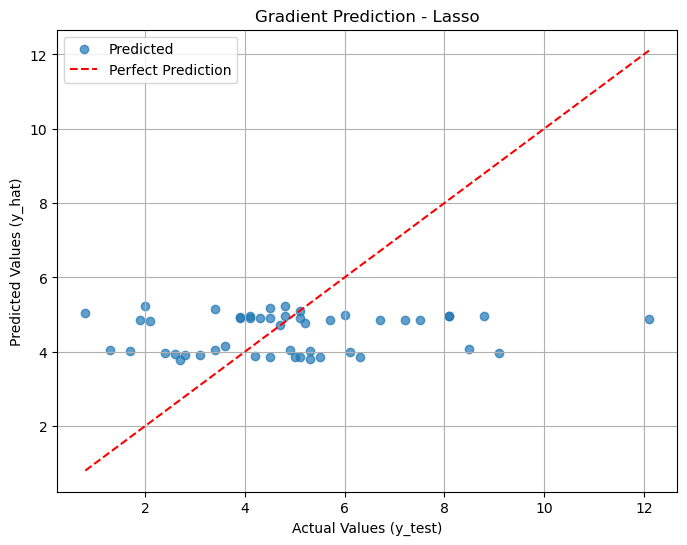

Lasso score: 0.08805036826951185
Lasso CMSE: 4.961068722695182


In [36]:
lasso = LassoCV(cv=bestMSEi).fit(X_train,y_train) # using the best fold number for mse found in kfold
y_pred = lasso.predict(X_test)
plot_y_yhat(y_test, y_pred, plot_title='Gradient Prediction - Lasso')
print('Lasso score:',lasso.score(X_train,y_train))
print('Lasso CMSE:', error_metric(y_test, y_pred, c_test))

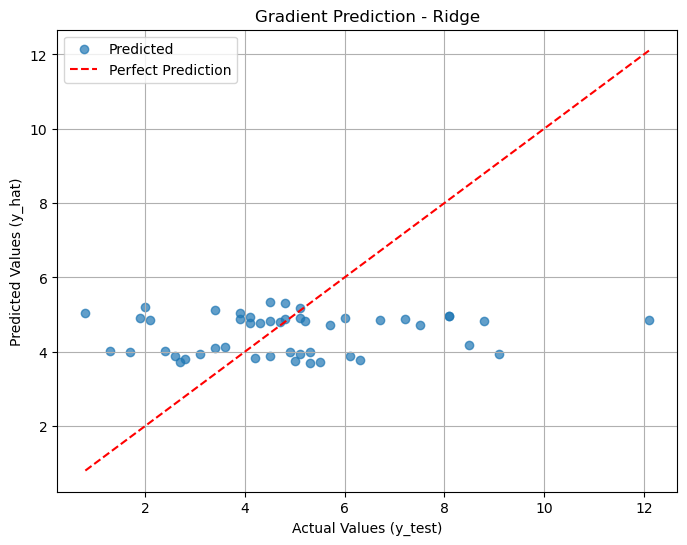

Ridge score: 0.08991301777345206
Ridge CMSE: 5.028989461177748


In [37]:
ridge = RidgeCV(cv=bestMSEi).fit(X_train,y_train)
y_pred = ridge.predict(X_test)
plot_y_yhat(y_test, y_pred, plot_title='Gradient Prediction - Ridge')
print('Ridge score:',ridge.score(X_train,y_train))
print('Ridge CMSE:', error_metric(y_test, y_pred, c_test))

The cmse values seem to still have a wide range, but they are constantly better than what ridge and lasso return

In [38]:
valid_rows = simpleTestDF.notna().all(axis=1)
predictions = np.full(simpleTestDF.shape[0], np.nan) #start all at NaN

predictions[valid_rows] = predict_with_weight(simpleTestDF[valid_rows], optimal_alpha=optimal_alpha)
mean_prediction = np.nanmean(predictions) #calculate the mean of the predictions
predictions[np.isnan(predictions)] = mean_prediction #pass NaN values to mean

In [39]:
solution_mean = predictions.mean()
solution_mean

4.241586946380662

In [40]:
create_submission_csv(predictions, 'cMSE-baseline-submission-02.csv')

CSV file 'cMSE-baseline-submission-02.csv' has been created.


## Task 2 Nonlinear models

### Task 2.1 Development

In [41]:
import statistics

This function creates a polynomial regression pipeline that drops or transforms specific columns, scales the data, applies polynomial feature transformation for a given degree, and then returns said pipeline.

In [42]:
def create_poly_pipeline(model, degree, columns_to_drop=[], transformations=None, colsToTransform=[]):
    preprocessor = ColumnTransformer(
        transformers=[
            ('column_dropper', 'drop', columns_to_drop), 
            ('transformation', FunctionTransformer(transformations), colsToTransform),
        ],
        remainder='passthrough'
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),      
        ('scaler', StandardScaler()),        
        ('poly_features', PolynomialFeatures(degree=degree)),  
        ('model', model) 
    ])
    
    return pipeline

In [43]:
def validate_poly_regression(X_train, y_train, c_train, X_test, y_test, c_test, regressor=None, degrees=range(1, 10), max_features=None):
    if regressor is None:
        regressor = LinearRegression()

    best_cmse = float('inf')
    best_model = None
    best_degree = 0
    cmse_per_degree = []
    worst_cmse = 0

    for degree in degrees:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=degree)),
            ('regressor', regressor)
        ])

        pipeline.fit(X_train, y_train)

        y_val_pred = pipeline.predict(X_test)

        cmse = error_metric(y_test, y_val_pred, c_test)
        cmse_per_degree.append(cmse)

        poly_features = pipeline.named_steps['poly']
        print(f"Degree: {degree}, Number of features: {poly_features.n_output_features_}, CMSE: {cmse}")

        if cmse < best_cmse:
            best_cmse = cmse
            best_model = pipeline
            best_degree = degree
        if cmse > worst_cmse:
            worst_cmse = cmse

    print(f"Best degree: {best_degree}, Best CMSE: {best_cmse}")

    return best_model, best_cmse, best_degree, cmse_per_degree, worst_cmse

In [44]:
def polynomial_and_plot_histograms(sample_fractions, num_runs, X_train, y_train, c_train, X_test, y_test, c_test, regression_model, degrees=range(1, 7)):
    best_degree_results = {fraction: [] for fraction in sample_fractions}
    best_cmse = float('inf')
    worst_cmse = 0
    all_cmse = []

    for fraction in sample_fractions:
        for run in range(1, num_runs + 1):
            print(f"Running sample fraction: {fraction * 100:.0f}%, Run number: {run}")

            X_train_sampled, y_train_sampled, c_train_sampled = resample(X_train, y_train, c_train, n_samples=int(fraction * len(X_train)), random_state=None)

            _, cmse, best_degree, cmse_per_degree, worst_cmse = validate_poly_regression(X_train_sampled, y_train_sampled, c_train_sampled, X_test, y_test, c_test, regressor=regression_model, degrees=degrees)
            best_degree_results[fraction].append(best_degree)
            if best_cmse > cmse:
                best_cmse = cmse
            if worst_cmse < cmse:
                worst_cmse = cmse
            all_cmse.extend(cmse_per_degree)
            
    for fraction in sample_fractions:
        plt.figure(figsize=(8, 6))
        bins = np.arange(0.5, 7.5, 1)
        plt.hist(best_degree_results[fraction], bins=bins, alpha=0.7, edgecolor='black')

        plt.title(f"Histogram of Best Degrees with {fraction * 100:.0f}% of data")
        plt.xlabel("Degree")
        plt.ylabel("Frequency")
        plt.xticks(ticks=np.arange(1, 7, 1))
        plt.grid(axis='y')
        plt.show()

    all_best_degrees = [degree for degrees_list in best_degree_results.values() for degree in degrees_list]

    degree_counter = Counter(all_best_degrees)
    final_best_degree = degree_counter.most_common(1)[0][0]

    #debugging prints
    median = sum(all_cmse) / len(all_cmse)
    sum1 = sum(all_cmse)
    len1 = len(all_cmse)
    print(f"sum is {sum1}")
    print(f"len is {len1}")
    
    print(f"The final best degree (most frequent) across all runs is: {final_best_degree}")
    print(f"The best cmse is {best_cmse}")
    print(f"The worst cmse is {worst_cmse}")
    print(f"The median cmse is {median}")
    print(f"The standard deviation cmse is {statistics.stdev(all_cmse)}")

Running sample fraction: 30%, Run number: 1
Degree: 1, Number of features: 5, CMSE: 2.7885184576444875
Degree: 2, Number of features: 15, CMSE: 4.534085832602567
Degree: 3, Number of features: 35, CMSE: 368.177148399353
Degree: 4, Number of features: 70, CMSE: 12671.743214985923
Degree: 5, Number of features: 126, CMSE: 1629319268.7555377
Degree: 6, Number of features: 210, CMSE: 515517304.54535407
Best degree: 1, Best CMSE: 2.7885184576444875
Running sample fraction: 30%, Run number: 2
Degree: 1, Number of features: 5, CMSE: 2.82163338423098
Degree: 2, Number of features: 15, CMSE: 5.007749307155609
Degree: 3, Number of features: 35, CMSE: 179.62136103312173
Degree: 4, Number of features: 70, CMSE: 8450.29342487989
Degree: 5, Number of features: 126, CMSE: 91182.99430991818
Degree: 6, Number of features: 210, CMSE: 37470.66293383059
Best degree: 1, Best CMSE: 2.82163338423098
Running sample fraction: 30%, Run number: 3
Degree: 1, Number of features: 5, CMSE: 3.4650982914594723
Degree:

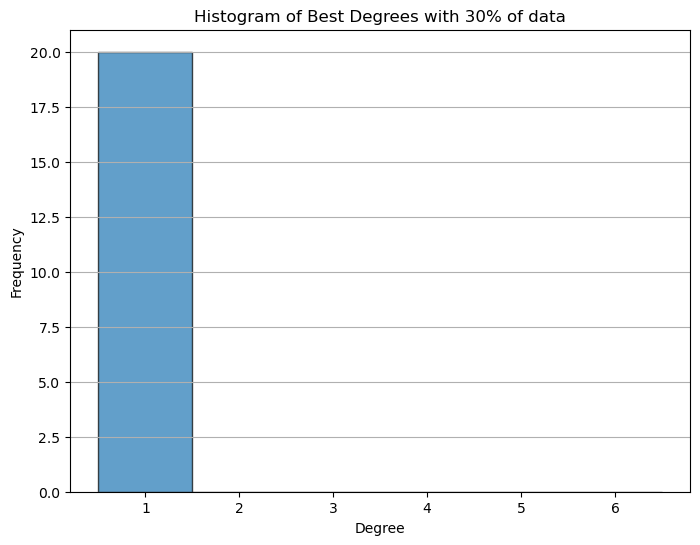

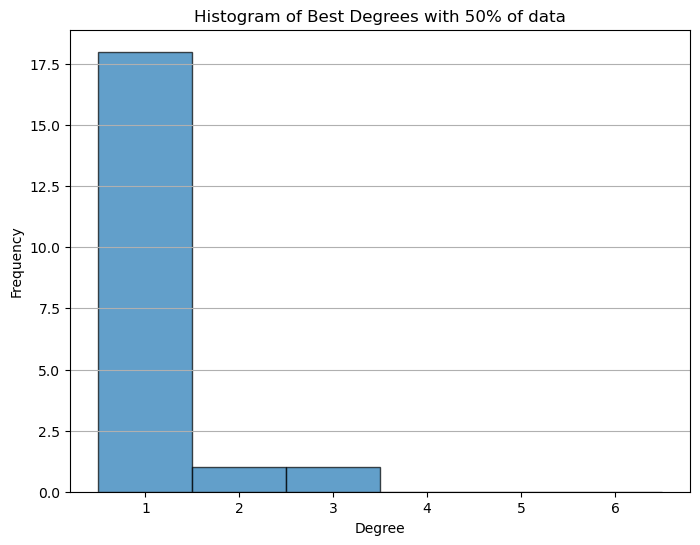

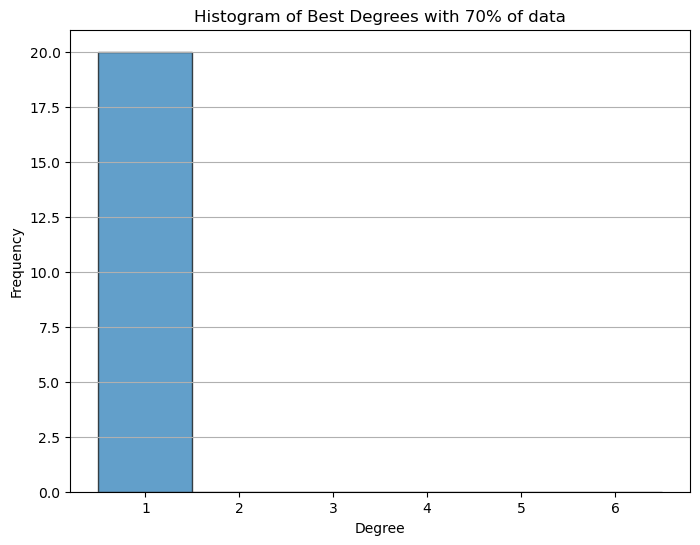

sum is 2.686285559459395e+27
len is 360
The final best degree (most frequent) across all runs is: 1
The best cmse is 2.5377880613064274
The worst cmse is 32691.32444174218
The median cmse is 7.461904331831652e+24
The standard deviation cmse is 1.1415425434684776e+26


In [45]:
X, y, c = baselineData(simpleDF)

X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(X, y, c, test_size=0.2)

polynomial_and_plot_histograms(sample_fractions=[0.3, 0.5, 0.7], num_runs=20, X_train=X_train, y_train=y_train,
                                    c_train=c_train, X_test=X_test, y_test=y_test, c_test=c_test, regression_model=None, degrees=range(1, 7))

In [46]:
# best_poly_model, best_poly_rmse, best_poly_degree, rmse_per_degree_poly, worst_cmse = validate_poly_regression(X_train, y_train, c_train, X_test, y_test, c_test, degrees=range(1, 7))
# y_pred = best_poly_model.predict(X_test)
# plot_y_yhat(y_test, y_pred, 'Polynomial regression')
# cmse = error_metric(y_test, y_pred, c_test)
# print(f"Polynomial regression censored Mean Squared Error: {cmse}")
# mse = root_mean_squared_error(y_test, y_pred)
# print(f"Polynomial regression Mean Squared Error: {mse}")

Running sample fraction: 30%, Run number: 1
Degree: 1, Number of features: 5, CMSE: 2.615802792485057
Degree: 2, Number of features: 15, CMSE: 4.5184737950827385
Degree: 3, Number of features: 35, CMSE: 7.577295924930337
Degree: 4, Number of features: 70, CMSE: 10.341126207723262
Degree: 5, Number of features: 126, CMSE: 15.452801569412642
Degree: 6, Number of features: 210, CMSE: 38.89937308129254
Best degree: 1, Best CMSE: 2.615802792485057
Running sample fraction: 30%, Run number: 2
Degree: 1, Number of features: 5, CMSE: 2.445623882366276
Degree: 2, Number of features: 15, CMSE: 2.5408997992510596
Degree: 3, Number of features: 35, CMSE: 5.725552243789022
Degree: 4, Number of features: 70, CMSE: 14.303469072519846
Degree: 5, Number of features: 126, CMSE: 17.32891023140372
Degree: 6, Number of features: 210, CMSE: 76.72544715558314
Best degree: 1, Best CMSE: 2.445623882366276
Running sample fraction: 30%, Run number: 3
Degree: 1, Number of features: 5, CMSE: 2.8053299735485964
Degr

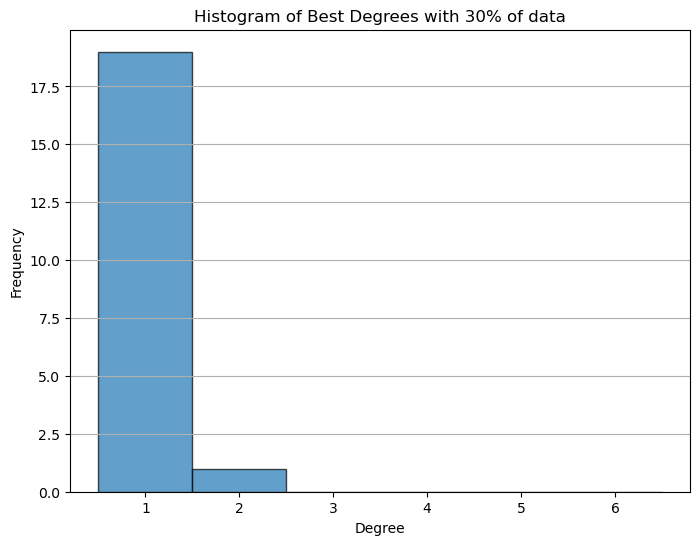

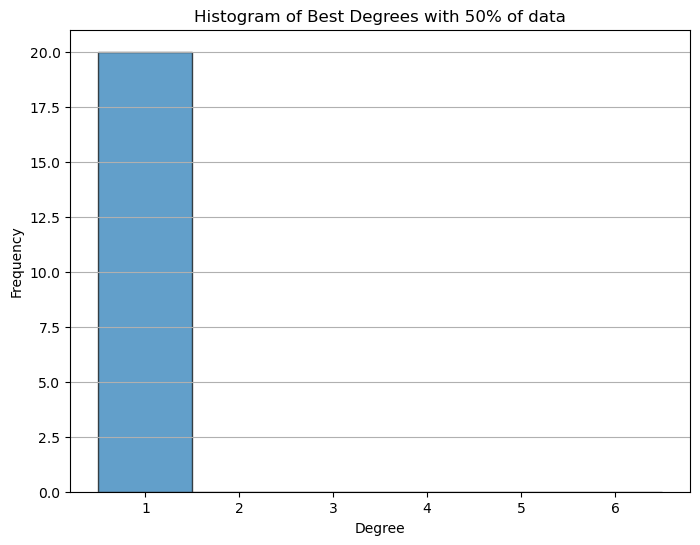

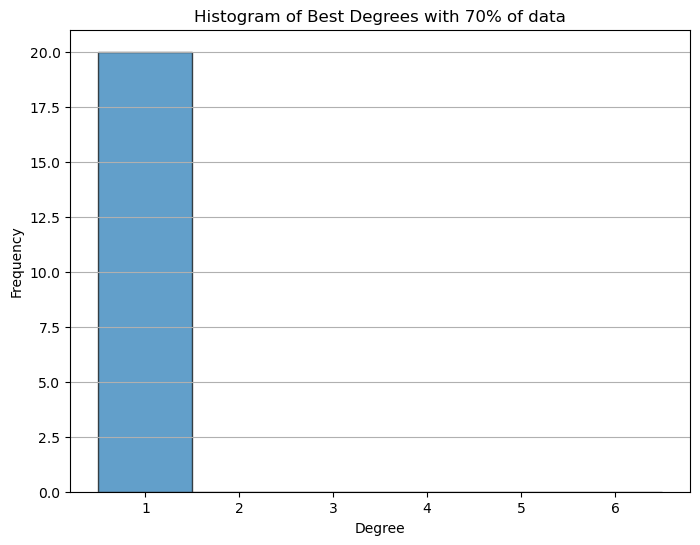

sum is 12068.224712461022
len is 360
The final best degree (most frequent) across all runs is: 1
The best cmse is 2.4126573204226087
The worst cmse is 52.91425526398114
The median cmse is 33.52284642350284
The standard deviation cmse is 91.53313845331729


In [47]:
from sklearn.linear_model import Ridge
polynomial_and_plot_histograms(sample_fractions=[0.3, 0.5, 0.7], num_runs=20, X_train=X_train, y_train=y_train,
                                    c_train=c_train, X_test=X_test, y_test=y_test, c_test=c_test, regression_model=Ridge(alpha=5.0), degrees=range(1, 7))

In [48]:
# best_poly_model, best_poly_rmse, best_poly_degree, rmse_per_degree_poly, worst_cmse = validate_poly_regression(X_train, y_train, c_train, X_test, y_test, c_test, degrees=range(1, 7))

# y_pred = best_poly_model.predict(X_test)
# plot_y_yhat(y_test, y_pred, 'Polynomial regression (with Ridge)')
# cmse = error_metric(y_test, y_pred, c_test)
# print(f"Polynomial regression (with Ridge) censored Mean Squared Error: {cmse}")
# mse = root_mean_squared_error(y_test, y_pred)
# print(f"Polynomial regression (with Ridge) Mean Squared Error: {mse}")

In [49]:
def validate_knn_regression(X_train, y_train, c_train, X_val, y_val, c_val, k=range(1,30)): # KNN neighbor range
    best_cmse = float('inf')
    best_model = None
    best_k = 0
    cmse_per_k = []
    max_cmse = 0
    errors = []

    for n in k:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', KNeighborsRegressor(n_neighbors=n))
        ])

        pipeline.fit(X_train, y_train)

        y_val_pred = pipeline.predict(X_val)

        cmse = error_metric(y_val, y_val_pred, c_val)
        cmse_per_k.append(cmse)

        print(f"K: {n}, CMSE: {cmse}")

        if cmse < best_cmse:
            best_cmse = cmse
            best_model = pipeline
            best_k = n
        if max_cmse < cmse:
            max_cmse = cmse
        errors.append(cmse)

    print(f"Best k: {best_k}, Best CMSE: {best_cmse}")

    return best_model, best_cmse, best_k, cmse_per_k, max_cmse, errors

knn_regression_best_model, best_cmse, best_k, cmse_per_k, max_cmse, errors = validate_knn_regression(X_train=X_train, y_train=y_train, c_train=c_train, X_val=X_test, y_val=y_test, c_val=c_test)


K: 1, CMSE: 4.091458333333334
K: 2, CMSE: 3.39703125
K: 3, CMSE: 3.279675925925926
K: 4, CMSE: 3.4322005208333337
K: 5, CMSE: 3.4908333333333332
K: 6, CMSE: 3.616695601851852
K: 7, CMSE: 3.5198001700680273
K: 8, CMSE: 3.3636979166666663
K: 9, CMSE: 3.145941358024691
K: 10, CMSE: 3.1528041666666664
K: 11, CMSE: 3.263267906336088
K: 12, CMSE: 3.2570818865740745
K: 13, CMSE: 3.13560157790927
K: 14, CMSE: 3.0479198554421765
K: 15, CMSE: 2.949616666666667
K: 16, CMSE: 2.9770768229166666
K: 17, CMSE: 2.879752739331027
K: 18, CMSE: 2.908229166666666
K: 19, CMSE: 2.9194032779316714
K: 20, CMSE: 2.8276895833333335
K: 21, CMSE: 2.809870086923658
K: 22, CMSE: 2.816226756198347
K: 23, CMSE: 2.7433412098298677
K: 24, CMSE: 2.808105107060186
K: 25, CMSE: 2.7848063333333335
K: 26, CMSE: 2.808145032051282
K: 27, CMSE: 2.800721021947874
K: 28, CMSE: 2.7975026573129256
K: 29, CMSE: 2.7714704716607215
Best k: 23, Best CMSE: 2.7433412098298677


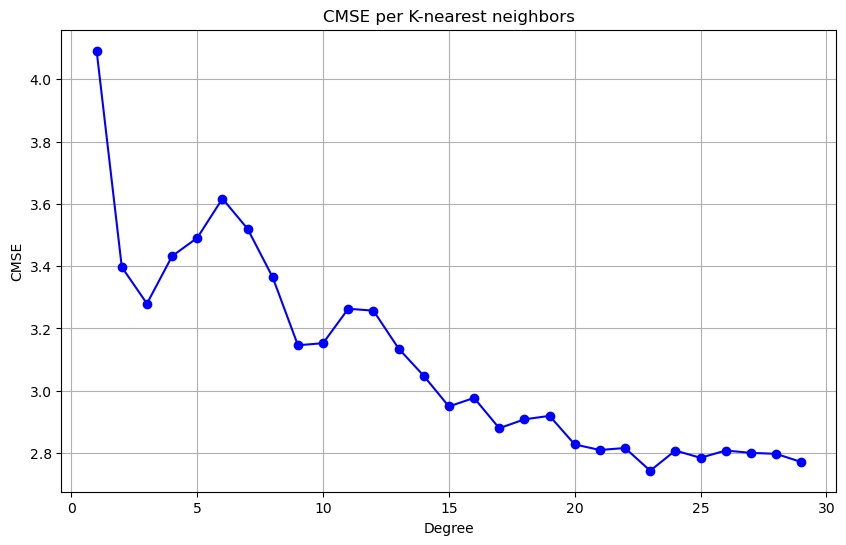

In [50]:
def plot_cmse_per_degree(degrees, cmse_per_degree, plot_title):
    plt.figure(figsize=(10, 6))
    plt.plot(degrees, cmse_per_degree, marker='o', linestyle='-', color='b')
    plt.title(plot_title)
    plt.xlabel("Degree")
    plt.ylabel("CMSE")
    plt.grid(True)
    plt.show()

plot_cmse_per_degree(range(1, 30), cmse_per_k, 'CMSE per K-nearest neighbors')

In [51]:
mean = sum(errors)/len(errors)
print(f"Mean cmse value is {mean}")
print(f"Max cmse value is {max_cmse}")

Mean cmse value is 3.096412646073437
Max cmse value is 4.091458333333334


In [52]:
valid_rows = simpleTestDF.notna().all(axis=1)
predictions = np.full(simpleTestDF.shape[0], np.nan) #start all at NaN

predictions[valid_rows] = knn_regression_best_model.predict(simpleTestDF[valid_rows])
mean_prediction = np.nanmean(predictions) #calculate the mean of the predictions
predictions[np.isnan(predictions)] = mean_prediction #pass NaN values to mean
predictions

array([4.46086957, 3.7826087 , 3.76086957, 4.92608696, 3.89130435,
       4.46086957, 4.14347826, 5.21304348, 3.4173913 , 3.83043478,
       4.45652174, 4.40434783, 4.30869565, 4.30434783, 5.13913043,
       3.79130435, 3.7826087 , 3.72173913, 5.14347826, 5.47391304,
       3.90869565, 4.40434783, 5.49565217, 3.93043478, 3.99565217,
       4.46086957, 5.44782609, 4.28695652, 3.77826087, 5.56521739,
       4.99565217, 4.84347826, 4.1826087 , 5.02173913, 5.49565217,
       5.57391304, 4.99565217, 5.56956522, 5.5173913 , 3.92173913,
       4.75217391, 4.03913043, 4.83043478, 3.9       , 5.21304348,
       4.99565217, 4.40434783, 4.84347826, 3.53913043, 5.06086957,
       3.79130435, 5.24347826, 4.43043478, 3.63913043, 4.47826087,
       3.77826087, 5.56521739, 3.68695652, 3.77826087, 3.5826087 ,
       5.57391304, 4.53913043, 5.1173913 , 5.49130435, 4.10869565,
       3.90434783, 4.28695652, 4.10434783, 4.84347826, 4.68695652,
       4.43043478, 4.75652174, 3.83043478, 3.90869565, 5.49565

In [53]:
simpleTestDF

,Age,Gender,Stage,TreatmentType
0,71.0,1,4,1
1,57.0,1,4,0
2,66.0,0,2,0
3,73.0,0,3,1
4,53.0,1,4,0
...,...,...,...,...
95,59.0,0,1,1
96,70.0,1,3,1
97,67.0,1,1,0
98,61.0,1,2,0


In [54]:
create_submission_csv(predictions, 'Nonlinear-submission-01.csv')

CSV file 'Nonlinear-submission-01.csv' has been created.


# Task 3

In [55]:
startDF

,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime,Censored
0,65.0,0,2,1.0,0,0.0,0.0,4.2,0
1,68.0,1,2,0.0,1,1.0,1.0,4.7,1
2,68.0,1,3,1.0,1,0.0,1.0,3.5,1
3,81.0,1,4,1.0,1,3.0,0.0,2.3,0
4,59.0,1,2,1.0,0,NaN,0.0,NaN,0
...,...,...,...,...,...,...,...,...,...
395,66.0,0,3,0.0,1,0.0,1.0,NaN,0
396,72.0,1,2,NaN,0,2.0,1.0,7.2,0
397,69.0,0,2,0.0,0,1.0,1.0,NaN,0
398,63.0,0,4,0.0,1,2.0,1.0,8.1,0


Trying a simple imputer first

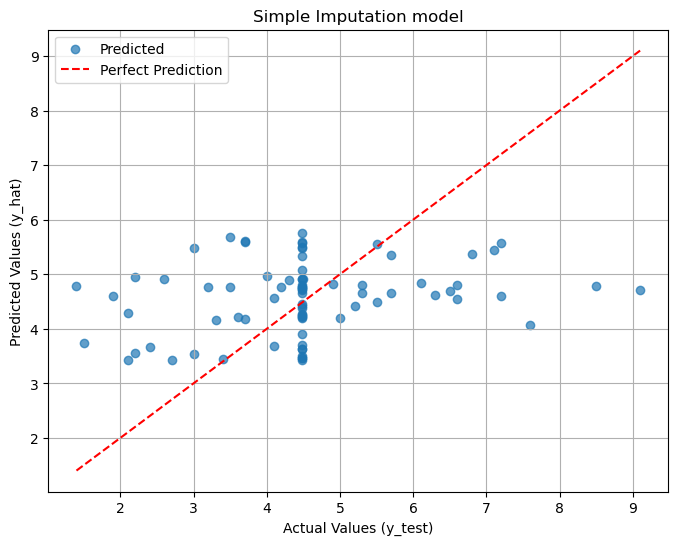

Censored Mean Squared Error: 1.566751398192294
Mean Squared Error: 1.4441539668363845


In [56]:
from sklearn.impute import SimpleImputer

c = trainDF['Censored']
X = trainDF.drop(columns=['SurvivalTime', 'Censored'])
y = trainDF['SurvivalTime']

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
y = imp.fit_transform(y.values.reshape(-1, 1)).ravel()

X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(X, y, c, test_size=0.2)

simple_imputation_model = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Use mean imputation for numerical features
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

simple_imputation_model.fit(X_train, y_train)

y_pred = simple_imputation_model.predict(X_test)
plot_y_yhat(y_test, y_pred, plot_title='Simple Imputation model')

cmse = error_metric(y_test, y_pred, c_test)
print("Censored Mean Squared Error:", cmse)
rmse = root_mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', rmse)

Checking the missing values distributions

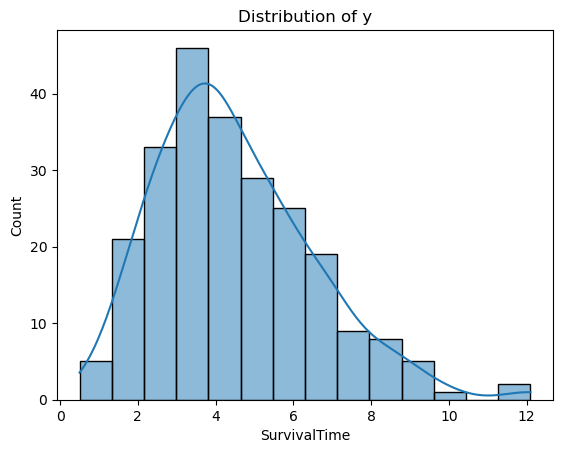

In [57]:
X, y, c = baselineData(startDF)

sns.histplot(y, kde=True)
plt.title("Distribution of y")
plt.show()

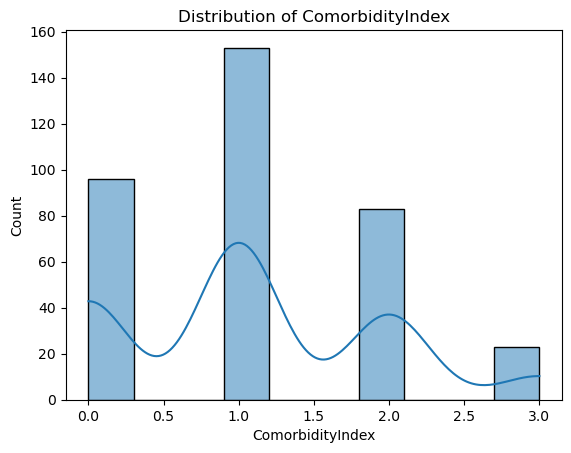

In [58]:
sns.histplot(X['ComorbidityIndex'], kde=True)
plt.title("Distribution of ComorbidityIndex")
plt.show()

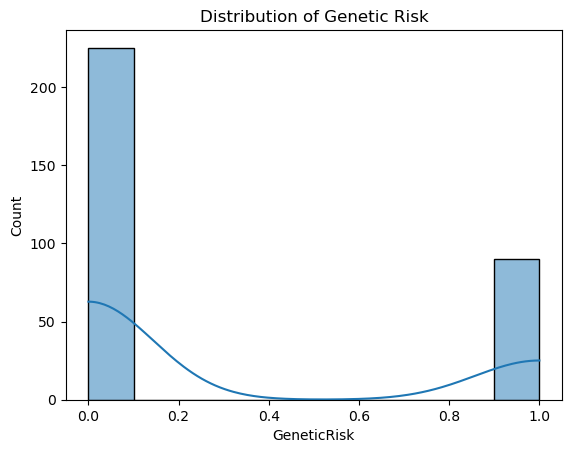

In [59]:
sns.histplot(X['GeneticRisk'], kde=True)
plt.title("Distribution of Genetic Risk")
plt.show()

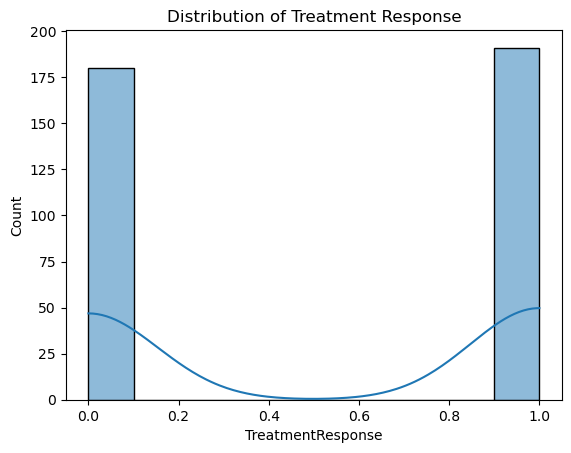

In [60]:
sns.histplot(X['TreatmentResponse'], kde=True)
plt.title("Distribution of Treatment Response")
plt.show()

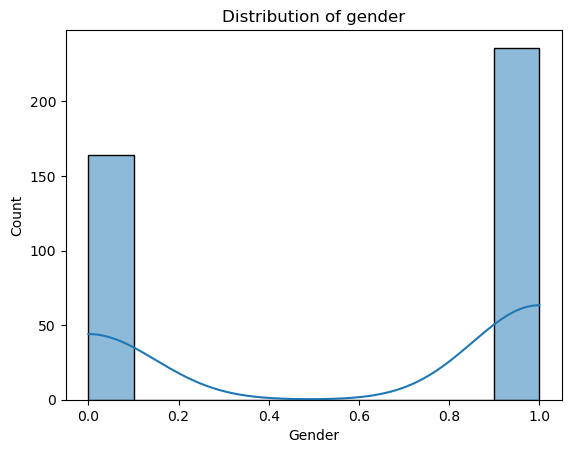

In [61]:
sns.histplot(X['Gender'], kde=True)
plt.title("Distribution of gender")
plt.show()

y has a skewed normal distribution.   
TreatmentResponse and ComorbidityIndex are booleans, with TreatmentResponse being balanced and ComorbidityIndex slightly skewed towards 0   
ComorbidityIndex takes integer values from 0 to 3, with 1 being more prevalent

Treatment Response and GeneticRisk are somewhat random and well distributed, so we'll do a simple imputation

Also, since we're analyzing Multiple Myeloma, a lot of these variables might influence Comorbidity Index (stage 3 patients being more likely to have other diseases than stage 1, for example), so we'll try to use predictive imputation for it.

In [118]:

def impute_data(X, y, c):

    if (y != []):
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')

        y = imp.fit_transform(y.values.reshape(-1, 1)).ravel()

    treatment_response_imputer = SimpleImputer(strategy='most_frequent')
    X['TreatmentResponse'] = treatment_response_imputer.fit_transform(X[['TreatmentResponse']])
    genetic_risk_imputer = SimpleImputer(strategy='most_frequent')
    X['GeneticRisk'] = genetic_risk_imputer.fit_transform(X[['GeneticRisk']])

    if (y != []):
        X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(X, y, c, test_size=0.2)
    else:
        X_train, X_test = train_test_split(X, test_size=0.2)
        y_train = y_test = c_train = c_test = []

    X_train_comorbidity_present = X_train[X_train['ComorbidityIndex'].notna()].drop(columns=['ComorbidityIndex'])
    y_train_comorbidity_present = X_train[X_train['ComorbidityIndex'].notna()]['ComorbidityIndex']
    X_train_comorbidity_missing = X_train[X_train['ComorbidityIndex'].isna()].drop(columns=['ComorbidityIndex'])

    model_comorbidity = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression()),
    ])
    model_comorbidity.fit(X_train_comorbidity_present, y_train_comorbidity_present)

    #Calculat ethe comorbidity index and switch the NaN values of our X_train for those
    predicted_comorbidity = model_comorbidity.predict(X_train_comorbidity_missing)
    X_train.loc[X_train_comorbidity_missing.index, 'ComorbidityIndex'] = predicted_comorbidity

    #same but for X_test
    X_test_comorbidity_missing = X_test[X_test['ComorbidityIndex'].isna()].drop(columns=['ComorbidityIndex'])

    predicted_comorbidity = model_comorbidity.predict(X_test_comorbidity_missing)
    X_test.loc[X_test_comorbidity_missing.index, 'ComorbidityIndex'] = predicted_comorbidity
    print(y)

    return X_train, X_test, y_train, y_test, c_train, c_test


In [63]:
X, y, c = baselineData(startDF)
X_train, X_test, y_train, y_test, c_train, c_test = impute_data(X, y, c)

[ 4.2         4.7         3.5         2.3         4.47958333  2.6
  4.47958333  4.47958333  4.47958333  6.4         4.47958333  4.1
  9.1         4.47958333  3.3         4.47958333  3.          4.7
  2.7         4.47958333  4.47958333  1.7         4.47958333  3.6
  4.47958333  4.47958333  5.1         5.3         4.47958333  4.47958333
  4.1         7.5         4.8         1.3         3.8         2.
  6.8         4.3         5.2         1.3         4.47958333  2.6
  3.3         6.4         4.47958333  4.47958333  1.9         3.4
  4.47958333  5.8         5.6         4.47958333  2.5         2.6
  5.8         0.5         4.47958333  4.47958333  5.2         4.47958333
  4.47958333  2.8         5.2         4.47958333  1.9         3.4
  3.9         6.8         4.1         4.          4.47958333  2.9
  7.4         4.          4.47958333  4.47958333  5.7         3.6
  4.47958333  7.3         3.9         6.8         4.47958333  4.3
  4.47958333  4.4         4.47958333  4.47958333  4.47958333  3

In [64]:
pipeline = pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', KNeighborsRegressor(n_neighbors=best_k))],
        )
pipeline.fit(X_train, y_train) 

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsRegressor(n_neighbors=23))])

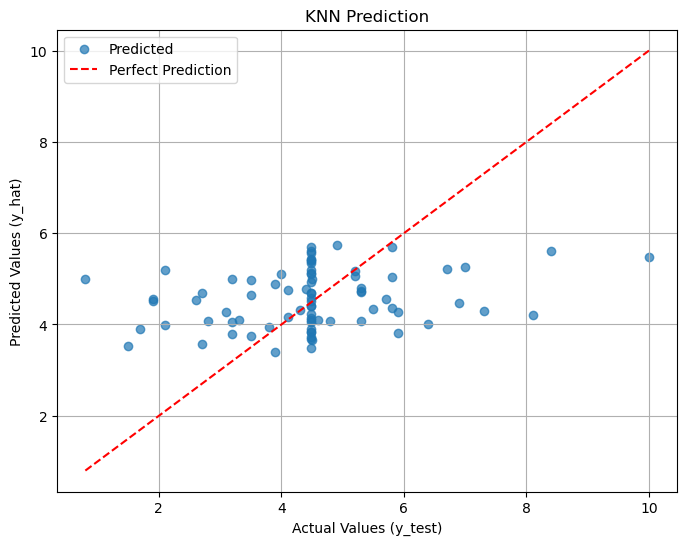

KNN censored Mean Squared Error: 1.9781025002830617


In [65]:
y_pred = pipeline.predict(X_test)
plot_y_yhat(y_test, y_pred, plot_title='KNN Prediction')
cmse = error_metric(y_test, y_pred, c_test)
print(f"KNN censored Mean Squared Error: {cmse}")

Our y is slightly skewed, so we'll try a median imputation instead of mean
TreatmentResponse and GeneticRisk are booleans. Treatment response has balanced distribution, GeneticRisk does not
ComorbidityIndex takes integer values between 0 and 3

Running sample fraction: 30%, Run number: 1
Degree: 1, Number of features: 8, CMSE: 2.0737011150550644
Degree: 2, Number of features: 36, CMSE: 2.961833206310579
Degree: 3, Number of features: 120, CMSE: 3.8483517363675497
Degree: 4, Number of features: 330, CMSE: 2.9777184369657403
Degree: 5, Number of features: 792, CMSE: 4.799498121326179
Degree: 6, Number of features: 1716, CMSE: 4.697507009147047
Best degree: 1, Best CMSE: 2.0737011150550644
Running sample fraction: 30%, Run number: 2
Degree: 1, Number of features: 8, CMSE: 2.0854215997303656
Degree: 2, Number of features: 36, CMSE: 2.5316682087461744
Degree: 3, Number of features: 120, CMSE: 3.897017463613267
Degree: 4, Number of features: 330, CMSE: 7.210376774261343
Degree: 5, Number of features: 792, CMSE: 8.759182826359705
Degree: 6, Number of features: 1716, CMSE: 11.596463339049382
Best degree: 1, Best CMSE: 2.0854215997303656
Running sample fraction: 30%, Run number: 3
Degree: 1, Number of features: 8, CMSE: 2.197889300572

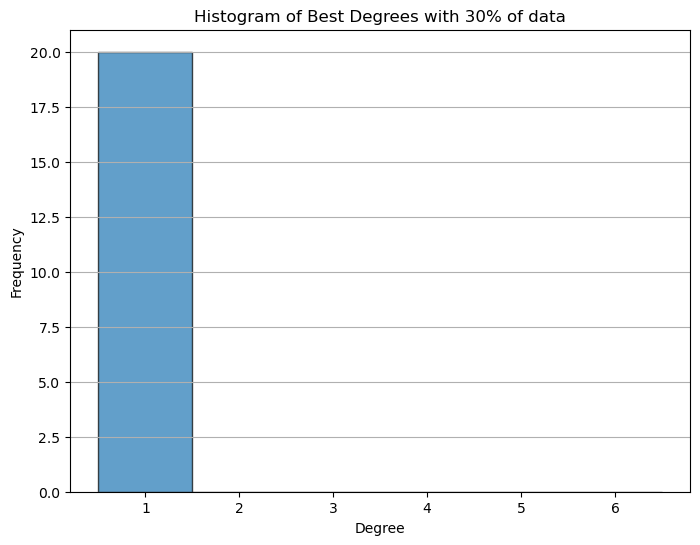

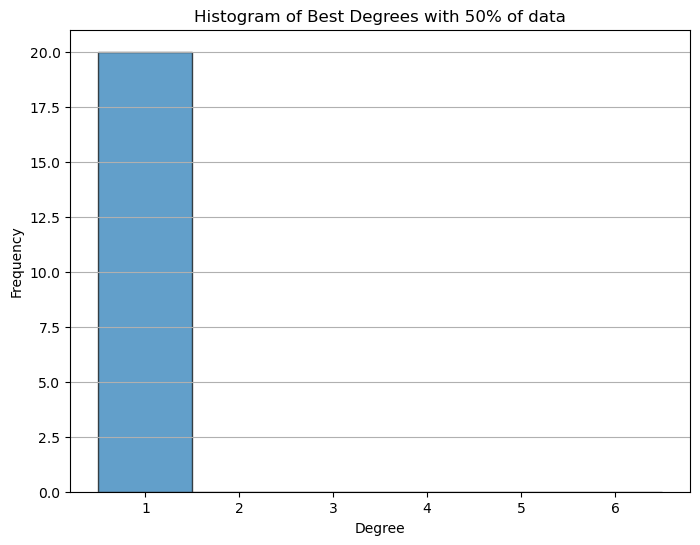

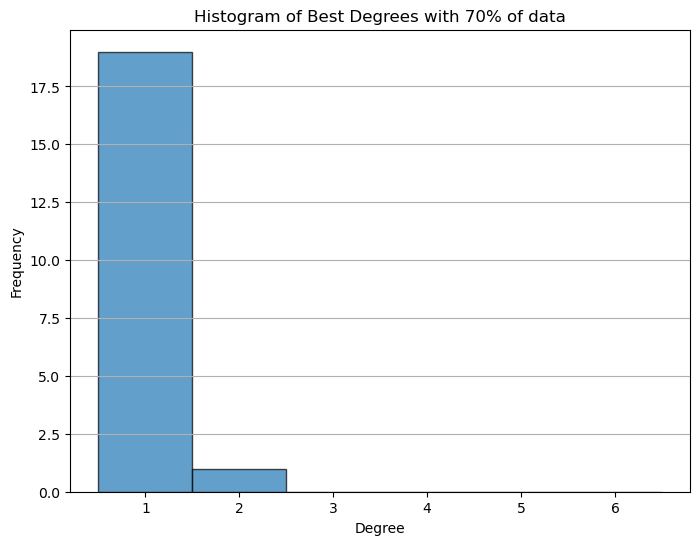

sum is 2407.0819960667363
len is 360
The final best degree (most frequent) across all runs is: 1
The best cmse is 1.967066748996401
The worst cmse is 9.31444166130071
The median cmse is 6.6863388779631565
The standard deviation cmse is 6.123059910045775


In [66]:
polynomial_and_plot_histograms(sample_fractions=[0.3, 0.5, 0.7], num_runs=20, X_train=X_train, y_train=y_train,
                                    c_train=c_train, X_test=X_test, y_test=y_test, c_test=c_test, regression_model=Ridge(alpha=5.0), degrees=range(1, 7)) # Ridge regularization + poly degrees

In [67]:
knn_regression_best_model, best_cmse, best_k, cmse_per_k, max_cmse, errors = validate_knn_regression(X_train=X_train, y_train=y_train, c_train=c_train, X_val=X_test, y_val=y_test, c_val=c_test)

K: 1, CMSE: 3.499656319444445
K: 2, CMSE: 3.247969329969618
K: 3, CMSE: 2.7760473861882717
K: 4, CMSE: 2.464762285563151
K: 5, CMSE: 2.4822196276909727
K: 6, CMSE: 2.2715147714723187
K: 7, CMSE: 2.238968452380952
K: 8, CMSE: 2.1578517487589517
K: 9, CMSE: 2.145490768550669
K: 10, CMSE: 2.182345404644097
K: 11, CMSE: 2.155233940344496
K: 12, CMSE: 2.109602781424817
K: 13, CMSE: 2.085561942133054
K: 14, CMSE: 2.0337619128999256
K: 15, CMSE: 2.082263253452932
K: 16, CMSE: 2.0731287841966415
K: 17, CMSE: 2.1049745001321605
K: 18, CMSE: 2.0590645333397632
K: 19, CMSE: 2.084003362128251
K: 20, CMSE: 2.0353719314615883
K: 21, CMSE: 2.0160497945847897
K: 22, CMSE: 1.993298160390302
K: 23, CMSE: 1.9781025002830617
K: 24, CMSE: 1.978200624397184
K: 25, CMSE: 1.9710039331284726
K: 26, CMSE: 2.0098881590544875
K: 27, CMSE: 2.0093032299733986
K: 28, CMSE: 1.99636856805157
K: 29, CMSE: 2.0021084882337705
Best k: 25, Best CMSE: 1.9710039331284726


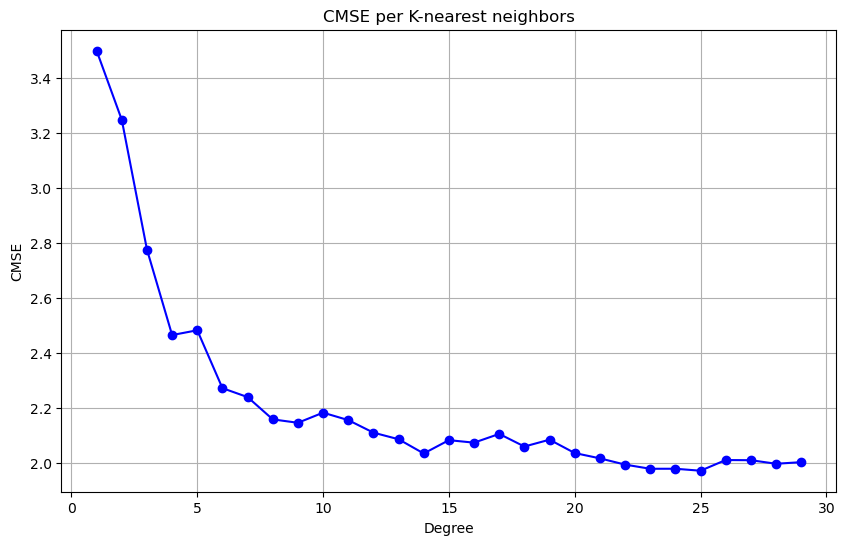

In [68]:
plot_cmse_per_degree(range(1, 30), cmse_per_k, 'CMSE per K-nearest neighbors')

## 3.2 Train models that do not require imputation

In [99]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from catboost import CatBoostRegressor, Pool

HistGrad_model = HistGradientBoostingRegressor()

In [100]:
df = startDF.dropna(subset=['SurvivalTime'])    # HistGradientBoostingRegressor and Catboost still can't deal with NaN values at y
X, y, c = baselineData(df) 
X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(X, y, c)

In [101]:
HistGrad_model.fit(X_train, y_train)

HistGradientBoostingRegressor()

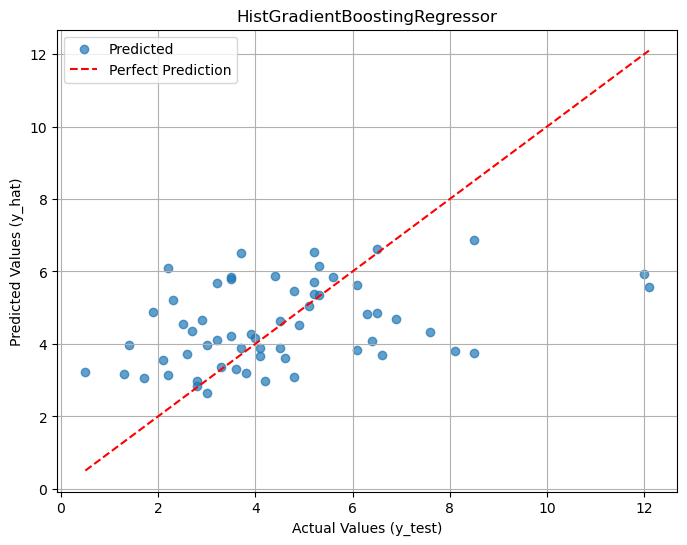

Censored Mean Squared Error: 3.8249519806527794
Mean Squared Error: 2.11384740495237


In [102]:
y_pred = HistGrad_model.predict(X_test)
plot_y_yhat(y_test, y_pred, plot_title='HistGradientBoostingRegressor')
cmse = error_metric(y_test, y_pred, c_test)
print(f"Censored Mean Squared Error: {cmse}")
mse = root_mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}") 

None of our features are categorical (non-number)

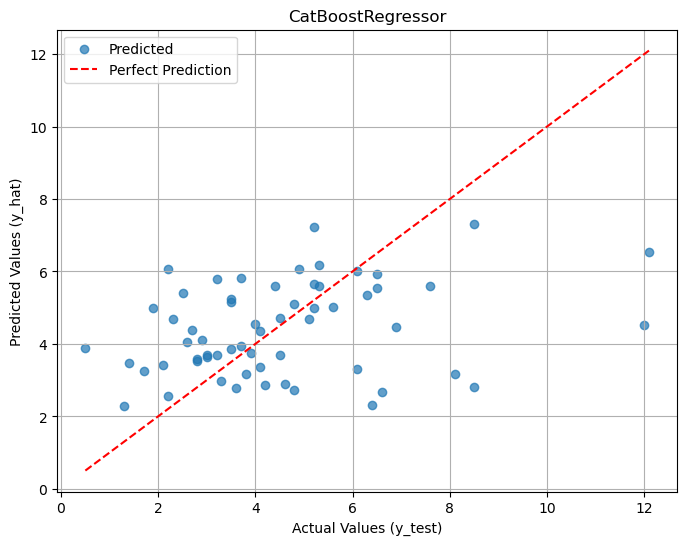

censored Mean Squared Error: 4.467081525662737
Mean Squared Error: 2.2468588477101856


In [103]:
CatBoost_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=0)
CatBoost_model.fit(X_train, y_train)

y_pred = CatBoost_model.predict(X_test)

plot_y_yhat(y_test, y_pred, plot_title='CatBoostRegressor')

cmse = error_metric(y_test, y_pred, c_test)
print(f"censored Mean Squared Error: {cmse}")
mse = root_mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

In [104]:
# y_lower: Lower bound of survival time
# y_upper: Upper bound of survival time
def prepare_aft_data(X, y, c):
    #In order to use right-censored data in catboost use -1 to express +inf
    y_lower = y
    y_upper = np.where(c == 1, y, -1)
    return y_lower, y_upper

In [105]:
#different distributions for catboost Accelerated Failure Time (AFT) model
def validate_catboost_aft(X_train, y_train, c_train, X_test, y_test, c_test, 
                           distributions=['Normal', 'Logistic', 'Extreme'], 
                           scales=[1.0, 1.2, 2.0]):
    
    y_train_lower, y_train_upper = prepare_aft_data(X_train, y_train, c_train)
    y_true_lower, y_true_upper = prepare_aft_data(X_test, y_test, c_test)
    
    #CatBoost pools
    train_pool = Pool(X_train, label=np.column_stack([y_train_lower, y_train_upper]))
    test_pool = Pool(X_test, label=np.column_stack([y_true_lower, y_true_upper]))
    results = []
    
    for dist in distributions:
        for scale in scales:
            model = CatBoostRegressor(
                iterations=500,
                learning_rate=0.1,
                loss_function=f'SurvivalAft:dist={dist };scale={scale}',
                eval_metric='SurvivalAft',
                verbose=0
            )
            model.fit(train_pool, eval_set=test_pool)
            
            # Predict and calculate interval MAE
            y_pred = model.predict(test_pool, prediction_type='Exponent')
            
            interval_mae = np.mean(
                np.where(
                    (y_true_lower <= y_pred) & (y_pred <= y_true_upper), 
                    0, 
                    np.minimum(np.abs(y_true_lower - y_pred), 
                               np.abs(y_true_upper - y_pred))
                )
            )
            
            results.append({
                'distribution': dist,
                'scale': scale,
                'interval_mae': interval_mae,
                'model': model
            })
            
            print(f"Distribution: {dist}, Scale: {scale}, Interval MAE: {interval_mae}")
    
    best_result = min(results, key=lambda x: x['interval_mae'])
    
    return best_result['model'], best_result['interval_mae']

Distribution: Normal, Scale: 1.0, Interval MAE: 2.165813835329453
Distribution: Normal, Scale: 1.2, Interval MAE: 2.2360370454747587
Distribution: Normal, Scale: 2.0, Interval MAE: 2.260021026199753
Distribution: Logistic, Scale: 1.0, Interval MAE: 2.1763892687507895
Distribution: Logistic, Scale: 1.2, Interval MAE: 2.2392958341817146
Distribution: Logistic, Scale: 2.0, Interval MAE: 2.3000929033083963
Distribution: Extreme, Scale: 1.0, Interval MAE: 2.050779277031689
Distribution: Extreme, Scale: 1.2, Interval MAE: 2.3530345598057334
Distribution: Extreme, Scale: 2.0, Interval MAE: 2.4127742781322756


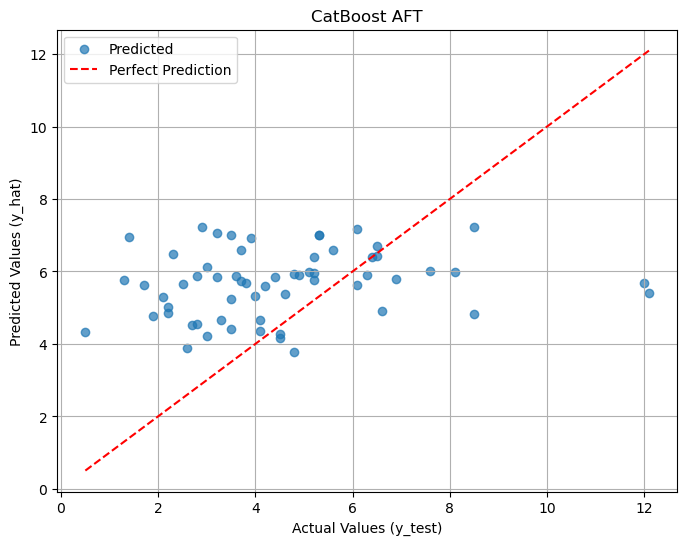

CatBoost AFT censored Mean Squared Error: 5.589201472935084
CatBoost AFT Mean Squared Error: 2.55800868600747


In [106]:
# Optional: Scale features (recommended for CatBoost)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

best_aft_model, best_interval_mae = validate_catboost_aft(
    X_train, y_train, c_train, 
    X_test, y_test, c_test
)

# Predict using the best model
y_pred = best_aft_model.predict(
    Pool(X_test), 
    prediction_type='Exponent'
)

plot_y_yhat(y_test, y_pred, plot_title='CatBoost AFT')
cmse = error_metric(y_test, y_pred, c_test)
print(f"CatBoost AFT censored Mean Squared Error: {cmse}")
mse = root_mean_squared_error(y_test, y_pred)
print(f"CatBoost AFT Mean Squared Error: {mse}")

In [107]:
X_train, X_test, y_train, y_test, c_train, c_test = impute_data(X, y, c)

[ 4.2  4.7  3.5  2.3  2.6  6.4  4.1  9.1  3.3  3.   4.7  2.7  1.7  3.6
  5.1  5.3  4.1  7.5  4.8  1.3  3.8  2.   6.8  4.3  5.2  1.3  2.6  3.3
  6.4  1.9  3.4  5.8  5.6  2.5  2.6  5.8  0.5  5.2  2.8  5.2  1.9  3.4
  3.9  6.8  4.1  4.   2.9  7.4  4.   5.7  3.6  7.3  3.9  6.8  4.3  4.4
  3.5  7.5  2.7  4.1  1.3  1.4  5.5  1.4  7.2  6.9  3.8  5.7  1.5  2.8
  2.8  6.7  6.9  5.8  2.1  4.4  3.7  5.5  2.6  3.8  5.5  4.5  2.6  4.7
  3.2  3.2  2.   6.1  3.8  3.5  6.9  2.9  2.1  2.1  3.1  3.9  2.7  2.9
  8.8 12.1  4.   4.5  6.6  3.9  8.3  3.2  4.8  2.8  4.5  2.7  4.8  4.5
  5.8  8.4  2.8  4.4  5.1  6.1  7.3  3.   2.2  4.9  2.   3.   2.5  2.6
  6.9  4.   4.4  6.3  5.2  3.2  3.7  3.7  5.5  3.7  4.3  5.8  1.7  5.3
  4.4  3.5  2.1  5.5  4.3  3.5  2.9  2.2  3.8  4.9  5.9  1.5  6.1  6.6
  8.2  6.5  3.8  2.3  2.4  8.8  1.7  3.6  5.   1.9  3.4  4.8  4.5  2.1
  4.6  2.8  3.9  4.8  3.8  5.7  4.1  4.9  4.1  4.1  7.1  6.1  8.5  5.
  9.5  5.8  2.4  6.3  3.1  5.2  3.6  6.1  7.2  4.6 12.   3.6  8.1  9.5
 10.   

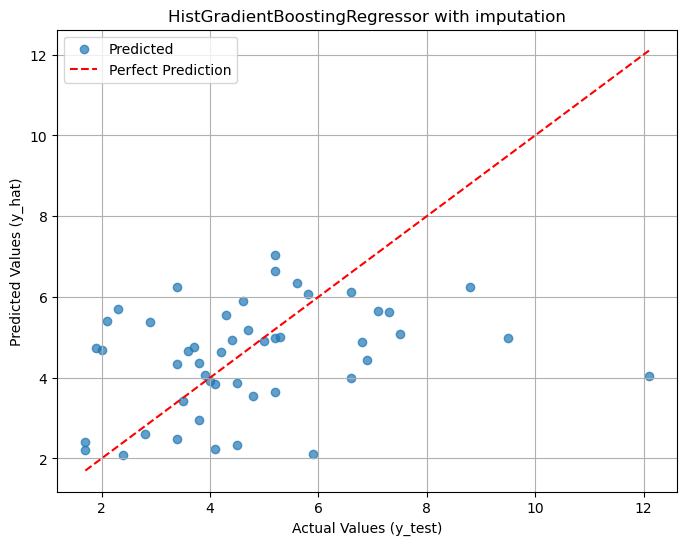

HistGradientBoostingRegressor censored Mean Squared Error: 4.222256441584798
HistGradientBoostingRegressor Mean Squared Error: 2.1134859243249724


In [108]:
HistGrad_model.fit(X_train, y_train)
y_pred = HistGrad_model.predict(X_test)

plot_y_yhat(y_test, y_pred, plot_title='HistGradientBoostingRegressor with imputation')
cmse = error_metric(y_test, y_pred, c_test)
print(f"HistGradientBoostingRegressor censored Mean Squared Error: {cmse}")
mse = root_mean_squared_error(y_test, y_pred)
print(f"HistGradientBoostingRegressor Mean Squared Error: {mse}")

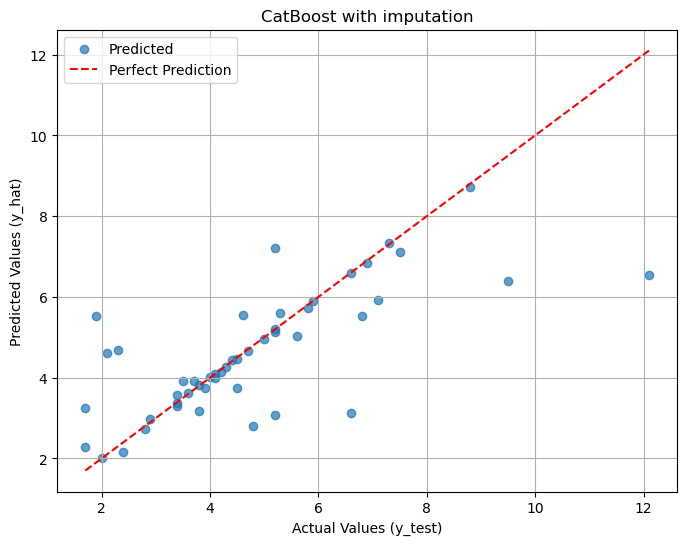

CatBoost censored Mean Squared Error: 2.061551668361636
CatBoost Mean Squared Error: 1.4360471614224248


In [109]:
y_pred = CatBoost_model.predict(X_test)

plot_y_yhat(y_test, y_pred, plot_title='CatBoost with imputation')
cmse = error_metric(y_test, y_pred, c_test)
print(f"CatBoost censored Mean Squared Error: {cmse}")
mse = root_mean_squared_error(y_test, y_pred)
print(f"CatBoost Mean Squared Error: {mse}")

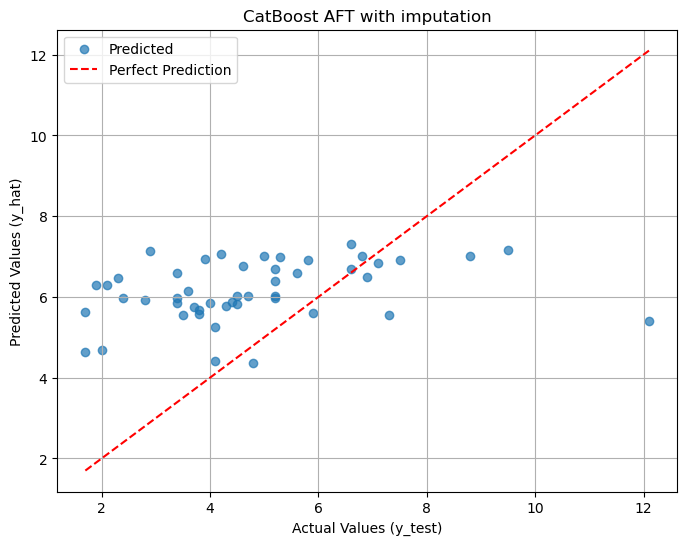

CatBoost AFT censored Mean Squared Error: 4.624650856517722
CatBoost AFT Mean Squared Error: 2.4132831939161616


In [110]:
y_train_lower, y_train_upper = prepare_aft_data(X_train, y_train, c_train)
y_true_lower, y_true_upper = prepare_aft_data(X_test, y_test, c_test)

#CatBoost pools
train_pool = Pool(X_train, label=np.column_stack([y_train_lower, y_train_upper]))
test_pool = Pool(X_test, label=np.column_stack([y_true_lower, y_true_upper]))

y_pred = best_aft_model.predict(test_pool, prediction_type='Exponent')
plot_y_yhat(y_test, y_pred, plot_title='CatBoost AFT with imputation')
cmse = error_metric(y_test, y_pred, c_test)
print(f"CatBoost AFT censored Mean Squared Error: {cmse}")
mse = root_mean_squared_error(y_test, y_pred)
print(f"CatBoost AFT Mean Squared Error: {mse}")

Simple imputation seemed to be constantly better in mse and cmse values compared to the other models, so we picked it.

In [119]:
predictions = simple_imputation_model.predict(testDF)

[]


In [121]:
create_submission_csv(predictions, 'handle-missing-submission-03.csv')

CSV file 'handle-missing-submission-03.csv' has been created.


## Task 4

In [83]:
from sklearn.base import BaseEstimator

class FrozenTransformer(BaseEstimator):
    def __init__(self, fitted_transformer):
        self.fitted_transformer = fitted_transformer

    def __getattr__(self, name):
        # `fitted_transformer`'s attributes are now accessible
        return getattr(self.fitted_transformer, name)

    def __sklearn_clone__(self):
        return self

    def fit(self, X, y=None):
        # Fitting does not change the state of the estimator
        return self

    def transform(self, X, y=None):
        # transform only transforms the data
        return self.fitted_transformer.transform(X)

    def fit_transform(self, X, y=None):
        # fit_transform only transforms the data
        return self.fitted_transformer.transform(X)

In [84]:
from sklearn.manifold import Isomap
from sklearn.pipeline import make_pipeline

# Impute missing values with the best imputers from Task 3.1
imp = SimpleImputer()
# X is the union of the unsupervised and (train) supervised feature datasets
X = imp.fit_transform(X)

scaler = StandardScaler()
X = scaler.fit_transform(X)
# Try different numbers of components.
iso = Isomap(n_components=2)
iso.fit(X)

pipe = make_pipeline(SimpleImputer(),
                     scaler,
                     FrozenTransformer(iso), # <- Here is the Frozen Isomap
                     LinearRegression())

# (X_train, y_train) is the labeled, supervised data
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('frozentransformer',
                 FrozenTransformer(fitted_transformer=Isomap())),
                ('linearregression', LinearRegression())])

Time's up, hands off the IDE